# Most important features for a player to be drafted ? A comparative analysis of Machine Learning model

### Table Of Content

1. Exploratory Data Analysis
2. Feature engineering to select the relevant subsets
3. Pre-processing
4. Evaluate the model
5. Hyperparameter fine tuning

# Aim

Identifying, by position and position type, the most important feature for a player to get drafted

# Content Summary

1. <b>Initial Data Exploration:</b><br>
    * In this section, we import the relevant packages to use for our analysis, and get a general feel of the data: Null value count, duplicate count, column count<br><br>
2. <b>Data Cleaning:</b><br>
    * <b>Outlier Analysis:</br>We look at outliers for each column by using the Z-score of 3. Any value with a standard deviation of 

# 1. Initial Data Exploration

<b> Importing Packages</b>

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

<b> Importing Data </b>

In [176]:
df = pd.read_csv('/Users/gregorycrooks/Downloads/NFL.csv')

In [65]:
df.head()

,Year,Player,Age,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,Drafted..tm.rnd.yr.,BMI,Player_Type,Position_Type,Position,Drafted
0,2009,Beanie Wells\WellCh00,20.0,Ohio St.,1.8542,106.594207,4.38,85.09,25.0,325.12,NaN,NaN,Arizona Cardinals / 1st / 31st pick / 2009,31.004194,offense,backs_receivers,RB,Yes
1,2009,Will Davis\DaviWi99,22.0,Illinois,1.8796,118.387609,4.84,83.82,27.0,292.10,7.38,4.45,Arizona Cardinals / 6th / 204th pick / 2009,33.510073,defense,defensive_lineman,DE,Yes
2,2009,Herman Johnson\JohnHe23,24.0,LSU,2.0066,165.107623,5.50,NaN,21.0,NaN,NaN,NaN,Arizona Cardinals / 5th / 167th pick / 2009,41.005821,offense,offensive_lineman,OG,Yes
3,2009,Rashad Johnson\JohnRa98,23.0,Alabama,1.8034,92.079251,4.49,93.98,15.0,304.80,7.09,4.23,Arizona Cardinals / 3rd / 95th pick / 2009,28.312463,defense,defensive_back,FS,Yes
4,2009,Cody Brown\BrowCo96,22.0,Connecticut,1.8796,110.676538,4.76,92.71,26.0,304.80,7.10,4.40,Arizona Cardinals / 2nd / 63rd pick / 2009,31.327425,defense,line_backer,OLB,Yes


<b>Column Count

In [66]:
len(df.columns)

18

Looking at the column types, we find:
1. <b> 11 Numerical columns </b>: Year, Age, Height, Weight, Sprint_40yd, Vertical_Jump, Bench_Press_Reps, Broad_Jump, Agility_3cone, Shuttle, BMI </br>

2. <b>7 Categorical columns </b>: Player, School, Drafted..tm.rnd.yr., Player_Type, Position_Type, Position, Drafted

In [67]:
df.dtypes

Year                     int64
Player                  object
Age                    float64
School                  object
Height                 float64
Weight                 float64
Sprint_40yd            float64
Vertical_Jump          float64
Bench_Press_Reps       float64
Broad_Jump             float64
Agility_3cone          float64
Shuttle                float64
Drafted..tm.rnd.yr.     object
BMI                    float64
Player_Type             object
Position_Type           object
Position                object
Drafted                 object
dtype: object

<b>Checking Duplicates

In [68]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF


,Year,Player,Age,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,Drafted..tm.rnd.yr.,BMI,Player_Type,Position_Type,Position,Drafted


<b> Identifying Null values </b>

We find that some columns have a high percentage of null values. At the <b>highest</b>, 35% of the "Drafted..tm.rnd.yr." column has 35% null values. Similarly, we find that most of the columns for performances in drills tend to have a higher percentage of null values.

In [69]:
(df.isnull().sum()/(len(df)))*100

Year                    0.000000
Player                  0.000000
Age                    15.818234
School                  0.000000
Height                  0.000000
Weight                  0.000000
Sprint_40yd             5.004314
Vertical_Jump          20.046017
Bench_Press_Reps       26.028185
Broad_Jump             20.937590
Agility_3cone          35.001438
Shuttle                32.786885
Drafted..tm.rnd.yr.    35.174001
BMI                     0.000000
Player_Type             0.000000
Position_Type           0.000000
Position                0.000000
Drafted                 0.000000
dtype: float64

# 2. Data Cleaning

### Outlier Analysis

Identifying outliers is important to detect any value which is disproportionately high or small, to the extent which it would have to be removed from the data (5000 bench press reps for instance). We set our z-score threshold of 3 (values with + 3 or - 3 standard deviations from the mean).

Let's inspect each relevant variable:
1. Age seems to have a high number of upper bound outliers, with players drafted at 21+ players being drafted after 24. We find 2 lower bound outliers with 2 players drafted at 18 and 19
2. For each of drill, we tend to find outliers for players performing poorly. Inversely, outside of Bench press (8 upper bound outliers) we do not find many outliers outclassing the other players.

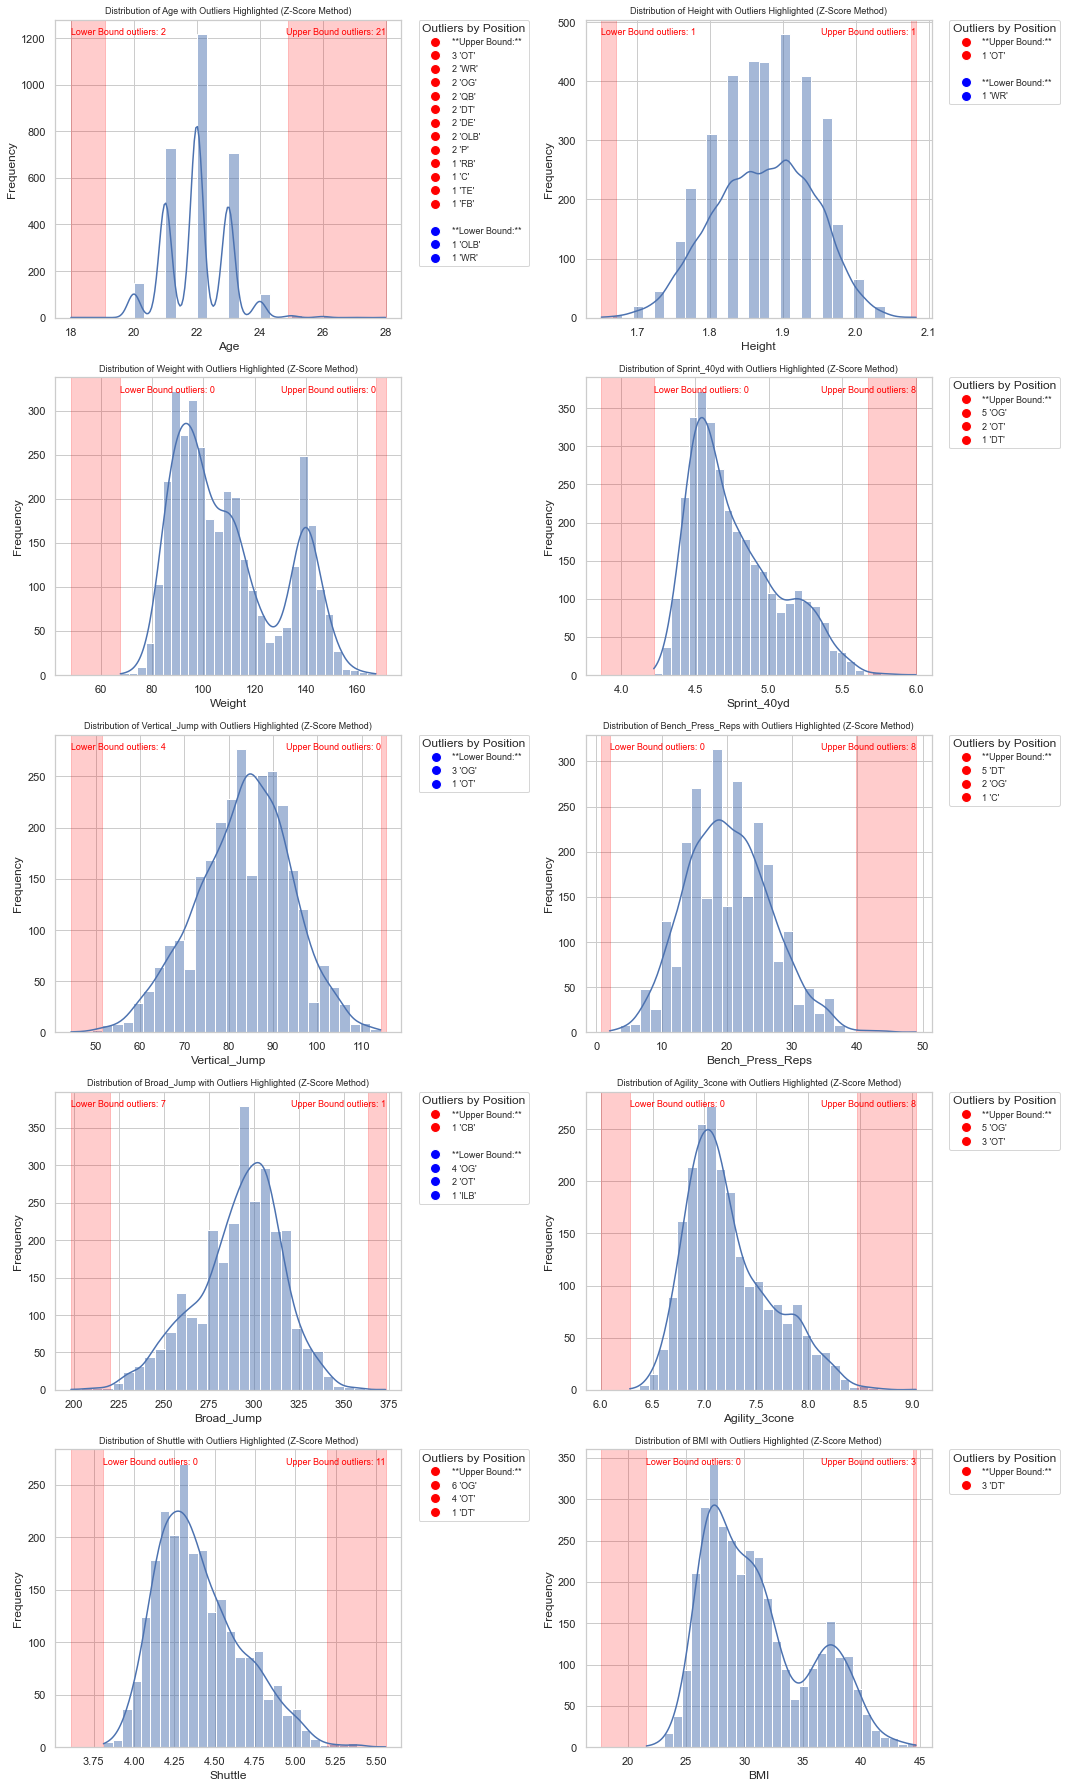

In [180]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Suppress the specific FutureWarning message
warnings.filterwarnings("ignore", category=FutureWarning, module="matplotlib.cbook")

# Select numerical columns, excluding 'Year'
num_cols = df.select_dtypes(include='number').columns
num_cols = num_cols[num_cols != 'Year']  # Exclude 'Year' column

# Set up the figure for subplots
n_cols = 2  # Number of columns for subplots
n_rows = len(num_cols) // n_cols + int(len(num_cols) % n_cols > 0)

plt.figure(figsize=(15, 5 * n_rows))

# Loop through each numerical variable and create a subplot
for i, col in enumerate(num_cols):
    # Calculate the mean and standard deviation, ignoring NaN values
    mean = np.nanmean(df[col].to_numpy())  # Convert to numpy array
    std_dev = np.nanstd(df[col].to_numpy())  # Convert to numpy array
    
    # Calculate the lower and upper bound values based on z-scores of -3 and 3
    lower = mean - 3 * std_dev
    upper = mean + 3 * std_dev
    
    # Identify and count outliers by position
    df['Upper_Bound_Outlier'] = df[col] >= upper
    df['Lower_Bound_Outlier'] = df[col] <= lower
    
    upper_outliers_count = df[df['Upper_Bound_Outlier']]['Position'].value_counts()
    lower_outliers_count = df[df['Lower_Bound_Outlier']]['Position'].value_counts()

    # Create subplot
    ax = plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col].dropna(), kde=True, ax=ax, bins=30)  # Drop NaN values for plotting

    # Highlighting the outliers
    ax.axvspan(xmin=df[col].min(), xmax=lower, alpha=0.2, color='red')
    ax.axvspan(xmin=upper, xmax=df[col].max(), alpha=0.2, color='red')

    # Adding text annotations for outlier counts
    ax.text(df[col].min(), ax.get_ylim()[1] * 0.95, f'Lower Bound outliers: {lower_outliers_count.sum()}', color='red', fontsize=9)
    ax.text(df[col].max(), ax.get_ylim()[1] * 0.95, f'Upper Bound outliers: {upper_outliers_count.sum()}', color='red', fontsize=9, horizontalalignment='right')

    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {col} with Outliers Highlighted (Z-Score Method)', fontsize=9)

    # Create custom legends for this graph
    legend_labels = []
    legend_patches = []
    
    if not upper_outliers_count.empty:
        upper_legend_labels = ['**Upper Bound:**'] + [f"{count} '{pos}'" for pos, count in upper_outliers_count.items()]
        legend_labels.extend(upper_legend_labels)
        legend_patches.extend([plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor='red') for label in upper_legend_labels])
    
    if not lower_outliers_count.empty:
        if not upper_outliers_count.empty:
            legend_labels.append('')  # To ensure space between different legend sections if needed
            legend_patches.append(plt.Line2D([0], [0], color='w'))
        
        lower_legend_labels = ['**Lower Bound:**'] + [f"{count} '{pos}'" for pos, count in lower_outliers_count.items()]
        legend_labels.extend(lower_legend_labels)
        legend_patches.extend([plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor='blue') for label in lower_legend_labels])
    
    if legend_labels:  # Only create a legend if there are labels to show
        ax.legend(handles=legend_patches, title='Outliers by Position', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=9)

plt.tight_layout()
plt.show()


### Formatting Errors

The <b> "Drafted..tm.rnd.yr." </b> contains information about the drafting team, round, pick rank, and year. Each value, if not null, has the following format: Arizona Cardinals / 1st / 31st pick / 2009. We clean this by separating this into 4 columns based on the "/" delimiter.

In [71]:
df[['Team','Round', "Pick", "Year"]] = df['Drafted..tm.rnd.yr.'].str.split('/',expand=True)

# Function to ensure only one space between words in each column
def normalize_spaces(s):
    if pd.isna(s):
        return s
    return ' '.join(s.split())

# Apply the function to each of the new columns
df['Team'] = df['Team'].apply(normalize_spaces)
df['Round'] = df['Round'].apply(normalize_spaces)
df['Pick'] = df['Pick'].apply(normalize_spaces)
df['Year'] = df['Year'].apply(normalize_spaces)

df = df.drop(columns=["Drafted..tm.rnd.yr."]) 

# Display the first few rows to verify the result
df[['Team', 'Round', 'Pick', 'Year']].head()

,Team,Round,Pick,Year
0,Arizona Cardinals,1st,31st pick,2009
1,Arizona Cardinals,6th,204th pick,2009
2,Arizona Cardinals,5th,167th pick,2009
3,Arizona Cardinals,3rd,95th pick,2009
4,Arizona Cardinals,2nd,63rd pick,2009


The <b> Round and Pick</b> columns are numerical and might provide relevant information. Let's remove all letters and convert them to numerical values:

In [72]:
import re
def omit_letters(s):
    if pd.isna(s):
        return s
    return re.sub('[^0-9]','', s)
df['Round'] = df['Round'].apply(omit_letters)
df['Pick'] = df['Pick'].apply(omit_letters)
df['Pick'] = df['Pick'].astype(float).astype('Int64')
df['Round'] = df['Round'].astype(float).astype('Int64')

The <b> "Player" </b> column values are occasionaly formatted with the player name followed by a backslash, and what looks to be a Username: "Beanie Wells\WellCh00". To resolve this, we remove the backslash symbol and any set of string after.

In [73]:
def normalize_spaces(s):
    if pd.isna(s):
        return s
    return ' '.join(s.split())

# Step 3: Apply the function to the 'Player' column to normalize spaces
df['Player'] = df['Player'].apply(normalize_spaces)

df['Player'] = df['Player'].str.split('\\').str[0]
df['Player'].head()

0      Beanie Wells
1        Will Davis
2    Herman Johnson
3    Rashad Johnson
4        Cody Brown
Name: Player, dtype: object

For the sake of better visualization, we have each first letter of the <b> Player Type</b> column in upper case format

In [74]:
df['Player_Type'] = df['Player_Type'].str.title()

df['Player_Type'].head()

0    Offense
1    Defense
2    Offense
3    Defense
4    Defense
Name: Player_Type, dtype: object

Likewise, values in the <b> "Position_Types" </b> column are oddly formatted. Let's replace them with improved formatting:

In [75]:
df["Position_Type"].value_counts()

backs_receivers       1260
defensive_back         657
offensive_lineman      555
defensive_lineman      501
line_backer            380
kicking_specialist     111
other_special           13
Name: Position_Type, dtype: int64

In [76]:
# Define the mapping dictionary
position_type_mapping = {
    "backs_receivers": "Backs/Receivers",
    "defensive_back": "Defensive Back",
    "offensive_lineman": "Offensive Lineman",
    "defensive_lineman": "Defensive Lineman",
    "line_backer": "Linebacker",
    "kicking_specialist": "Kicking Specialist",
    "other_special": "Other Special"
}

# Apply the mapping to the Position_Type column
df["Position_Type"] = df["Position_Type"].replace(position_type_mapping)
df["Position_Type"].head()

0      Backs/Receivers
1    Defensive Lineman
2    Offensive Lineman
3       Defensive Back
4           Linebacker
Name: Position_Type, dtype: object

<b> Improved formatting for Positions

In [77]:
# Create a dictionary to map acronyms to full position names
position_mapping = {
    'RB': 'Running Back',
    'DE': 'Defensive End',
    'OG': 'Offensive Guard',
    'FS': 'Free Safety',
    'OLB': 'Outside Linebacker',
    'DT': 'Defensive Tackle',
    'OT': 'Offensive Tackle',
    'CB': 'Cornerback',
    'SS': 'Strong Safety',
    'TE': 'Tight End',
    'ILB': 'Inside Linebacker',
    'C': 'Center',
    'FB': 'Fullback',
    'WR': 'Wide Receiver',
    'P': 'Punter',
    'K': 'Kicker',
    'QB': 'Quarterback',
    'LS': 'Long Snapper',
    'S': 'Safety',
    'DB': 'Defensive Back'
}

# Replace the position acronyms in the 'Position' column with their full names
df['Position'] = df['Position'].map(position_mapping)
df['Position'].unique()

array(['Running Back', 'Defensive End', 'Offensive Guard', 'Free Safety',
       'Outside Linebacker', 'Defensive Tackle', 'Offensive Tackle',
       'Cornerback', 'Strong Safety', 'Tight End', 'Inside Linebacker',
       'Center', 'Fullback', 'Wide Receiver', 'Punter', 'Kicker',
       'Quarterback', 'Long Snapper', 'Safety', 'Defensive Back'],
      dtype=object)

<b> Let's drop irrelevant columns:

Year is a duplicate of the already existing "Year" column

In [78]:
df = df.drop(columns=["Year"])

### Dealing with Null Values

<b> Team column:</b> The "Team" column has NAs for players with aren't drafted

In [79]:
df['Team'] = df['Team'].fillna("Not Drafted")


<b> Round column </b> let's create an arbitrary column for players which aren't drafted. Which will be used to find relationships with the drafted status.

In [80]:
df['Round'] = df['Round'].fillna(8)
df['Round'] = df['Round'].astype(int)
df['Round'].value_counts()

8    1223
3     361
4     356
5     337
1     329
2     328
6     284
7     259
Name: Round, dtype: int64

In [81]:
df.columns

Index(['Player', 'Age', 'School', 'Height', 'Weight', 'Sprint_40yd',
       'Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone',
       'Shuttle', 'BMI', 'Player_Type', 'Position_Type', 'Position', 'Drafted',
       'Team', 'Round', 'Pick'],
      dtype='object')

<b> Multivariate Linear Regression: </b>Identifying signifcant correlations for model predictor to fill missing values

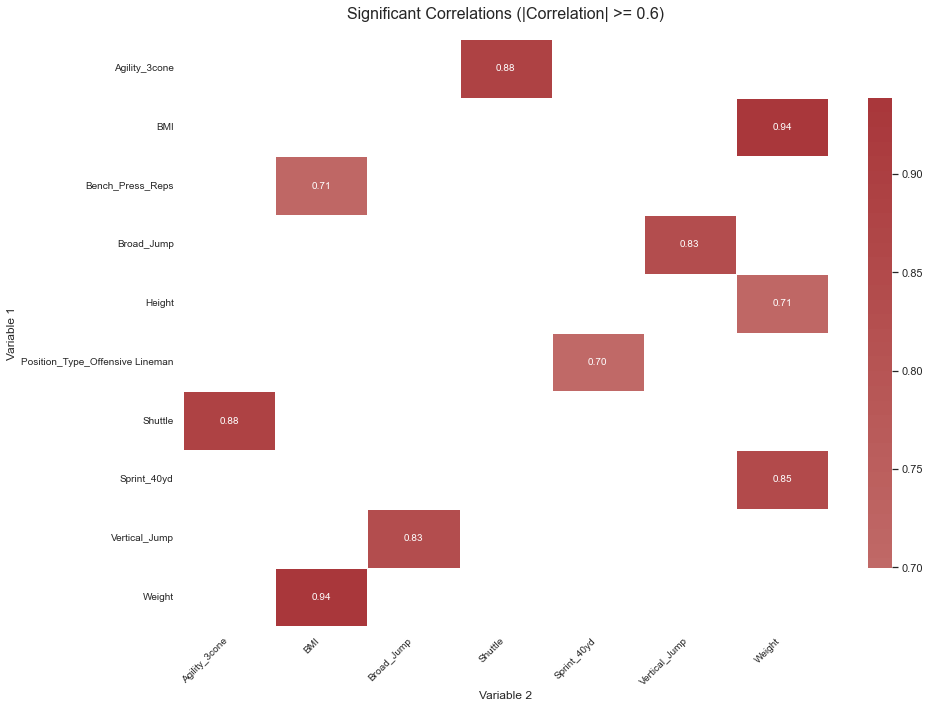

In [82]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Select the relevant columns including categorical ones
df_Regression = df.loc[:, ['Weight', 'Sprint_40yd', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', 'Vertical_Jump', 'Shuttle', 'BMI', 'Height', 'Drafted', 'Position_Type', 'Position']]

# One-hot encode the categorical variables
df_encoded = pd.get_dummies(df_Regression, columns=['Position', 'Position_Type'])

# Remove stratified columns if any
df_encoded = df_encoded[[x for x in df_encoded if not x.endswith('_Strat')]]    

# Step 1: Identify correlated columns (without taking absolute values to preserve sign)
correlation_matrix = df_encoded.corr()

# Find pairs with an absolute correlation of 60% or more
high_corr_pairs = correlation_matrix.stack().reset_index()
high_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Remove self-correlation pairs (correlations with themselves)
high_corr_pairs = high_corr_pairs[high_corr_pairs['Variable 1'] != high_corr_pairs['Variable 2']]

# Identify one-hot encoded variables
one_hot_encoded_vars = [col for col in df_encoded.columns if col.startswith('Position_') or col.startswith('Drafted_')]

# Exclude pairs where both variables are one-hot encoded
high_corr_pairs = high_corr_pairs[
    ~((high_corr_pairs['Variable 1'].isin(one_hot_encoded_vars)) & (high_corr_pairs['Variable 2'].isin(one_hot_encoded_vars)))
]

# Filter out correlations that are exactly 1 or -1 and keep only those with |Correlation| >= 0.6
high_corr_pairs = high_corr_pairs[(high_corr_pairs['Correlation'].abs() >= 0.6) & (high_corr_pairs['Correlation'].abs() < 1.0)]

# Sort by the absolute value of the correlation in descending order
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

# Keep only the highest absolute correlation for each unique Variable 1
unique_high_corr_pairs = high_corr_pairs.groupby('Variable 1').first().reset_index()

# Pivot the data for heatmap visualization
pivot_table = unique_high_corr_pairs.pivot(index='Variable 1', columns='Variable 2', values='Correlation')

# Plot the heatmap using Seaborn
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, annot=True, cmap='vlag', center=0, linewidths=1, linecolor='white', cbar_kws={'shrink': 0.8}, fmt='.2f', annot_kws={'size': 10})

# Customize the heatmap for better visual appeal
plt.title('Significant Correlations (|Correlation| >= 0.6)', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


<b> Multivariate linear Regression</b>: <br><br> We use multivariate <b> Linear Regression model</b> to replace null values. For each missing value within q numerical variable column, we find all the numerical variables which: 
1. Are non-null 
2. Have a strong correlation (positive or negative)

We also hot-one encode the categorical variables, and identify the most highly correlated values. Offensive linemen have a strong relationship with some of the numerical feature, so we include them to the regression model in order to predict the missing values.

In [83]:
import mpl_toolkits

In [84]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression


# Select the relevant columns including categorical ones
df_Regression = df.loc[:, ['Weight', 'Sprint_40yd', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', 'Vertical_Jump', 'Shuttle', 'BMI', 'Height', 'Drafted', 'Position_Type']]

# One-hot encode the categorical variables
df_encoded = pd.get_dummies(df_Regression, columns=['Drafted', 'Position_Type'])

#Remove strats
df_encoded = df_encoded[[x for x in df_encoded if not x.endswith('_Strat')]]    
# Step 1: Identify highly correlated columns
correlation_matrix = df_encoded.corr().abs()

# We want to find pairs with a correlation of 70% or more
high_corr_pairs = correlation_matrix.stack().reset_index()
high_corr_pairs = high_corr_pairs[high_corr_pairs['level_0'] != high_corr_pairs['level_1']]
high_corr_pairs = high_corr_pairs[high_corr_pairs[0] >= 0.6]

# Step 2: Function to predict and fill missing values using multiple explanatory variables
def fill_missing_values_multivariable(df, col_to_fill, explanatory_vars):
    # One hot encoding categorical variables to include in the predictor
    df = pd.get_dummies(df, columns=['Drafted', 'Position_Type'])
    # Separate the data into those with and without missing values
    non_null_df = df[df[col_to_fill].notnull()]
    null_df = df[df[col_to_fill].isnull()]
    # If there's no missing value, return the column as is
    if null_df.empty:
        return df[col_to_fill]
    
    # Ensure that we only use explanatory variables that are not null
    explanatory_vars = [var for var in explanatory_vars if var in df.columns and df[var].isnull().sum() == 0]
    
    
    # Train a linear regression model on non-null data
    X_train = non_null_df[explanatory_vars]
    y_train = non_null_df[col_to_fill]
    X_train
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict the missing values
    X_predict = null_df[explanatory_vars]
    y_predict = model.predict(X_predict)
    
    # Fill the missing values with the predictions
    df.loc[df[col_to_fill].isnull(), col_to_fill] = y_predict
    
    return df[col_to_fill]

# Step 3: Apply the model to fill missing values for each column
columns_to_predict = ['Shuttle', 'Height', 'Weight', 'Sprint_40yd', 'Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', "Age"]

for col in columns_to_predict:
    explanatory_vars = [c for c in columns_to_predict if c != col]
    df[col] = fill_missing_values_multivariable(df, col, explanatory_vars)

# Display the DataFrame after filling missing values
df = df[[x for x in df if not x.endswith('_Strat')]]  
df.head()

,Player,Age,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,BMI,Player_Type,Position_Type,Position,Drafted,Team,Round,Pick
0,Beanie Wells,20.0,Ohio St.,1.8542,106.594207,4.38,85.090000,25.0,325.120000,7.083763,4.358944,31.004194,Offense,Backs/Receivers,Running Back,Yes,Arizona Cardinals,1,31
1,Will Davis,22.0,Illinois,1.8796,118.387609,4.84,83.820000,27.0,292.100000,7.380000,4.450000,33.510073,Defense,Defensive Lineman,Defensive End,Yes,Arizona Cardinals,6,204
2,Herman Johnson,24.0,LSU,2.0066,165.107623,5.50,63.893789,21.0,243.153925,8.122168,4.949310,41.005821,Offense,Offensive Lineman,Offensive Guard,Yes,Arizona Cardinals,5,167
3,Rashad Johnson,23.0,Alabama,1.8034,92.079251,4.49,93.980000,15.0,304.800000,7.090000,4.230000,28.312463,Defense,Defensive Back,Free Safety,Yes,Arizona Cardinals,3,95
4,Cody Brown,22.0,Connecticut,1.8796,110.676538,4.76,92.710000,26.0,304.800000,7.100000,4.400000,31.327425,Defense,Linebacker,Outside Linebacker,Yes,Arizona Cardinals,2,63


<b>Age distribution by Position</b>

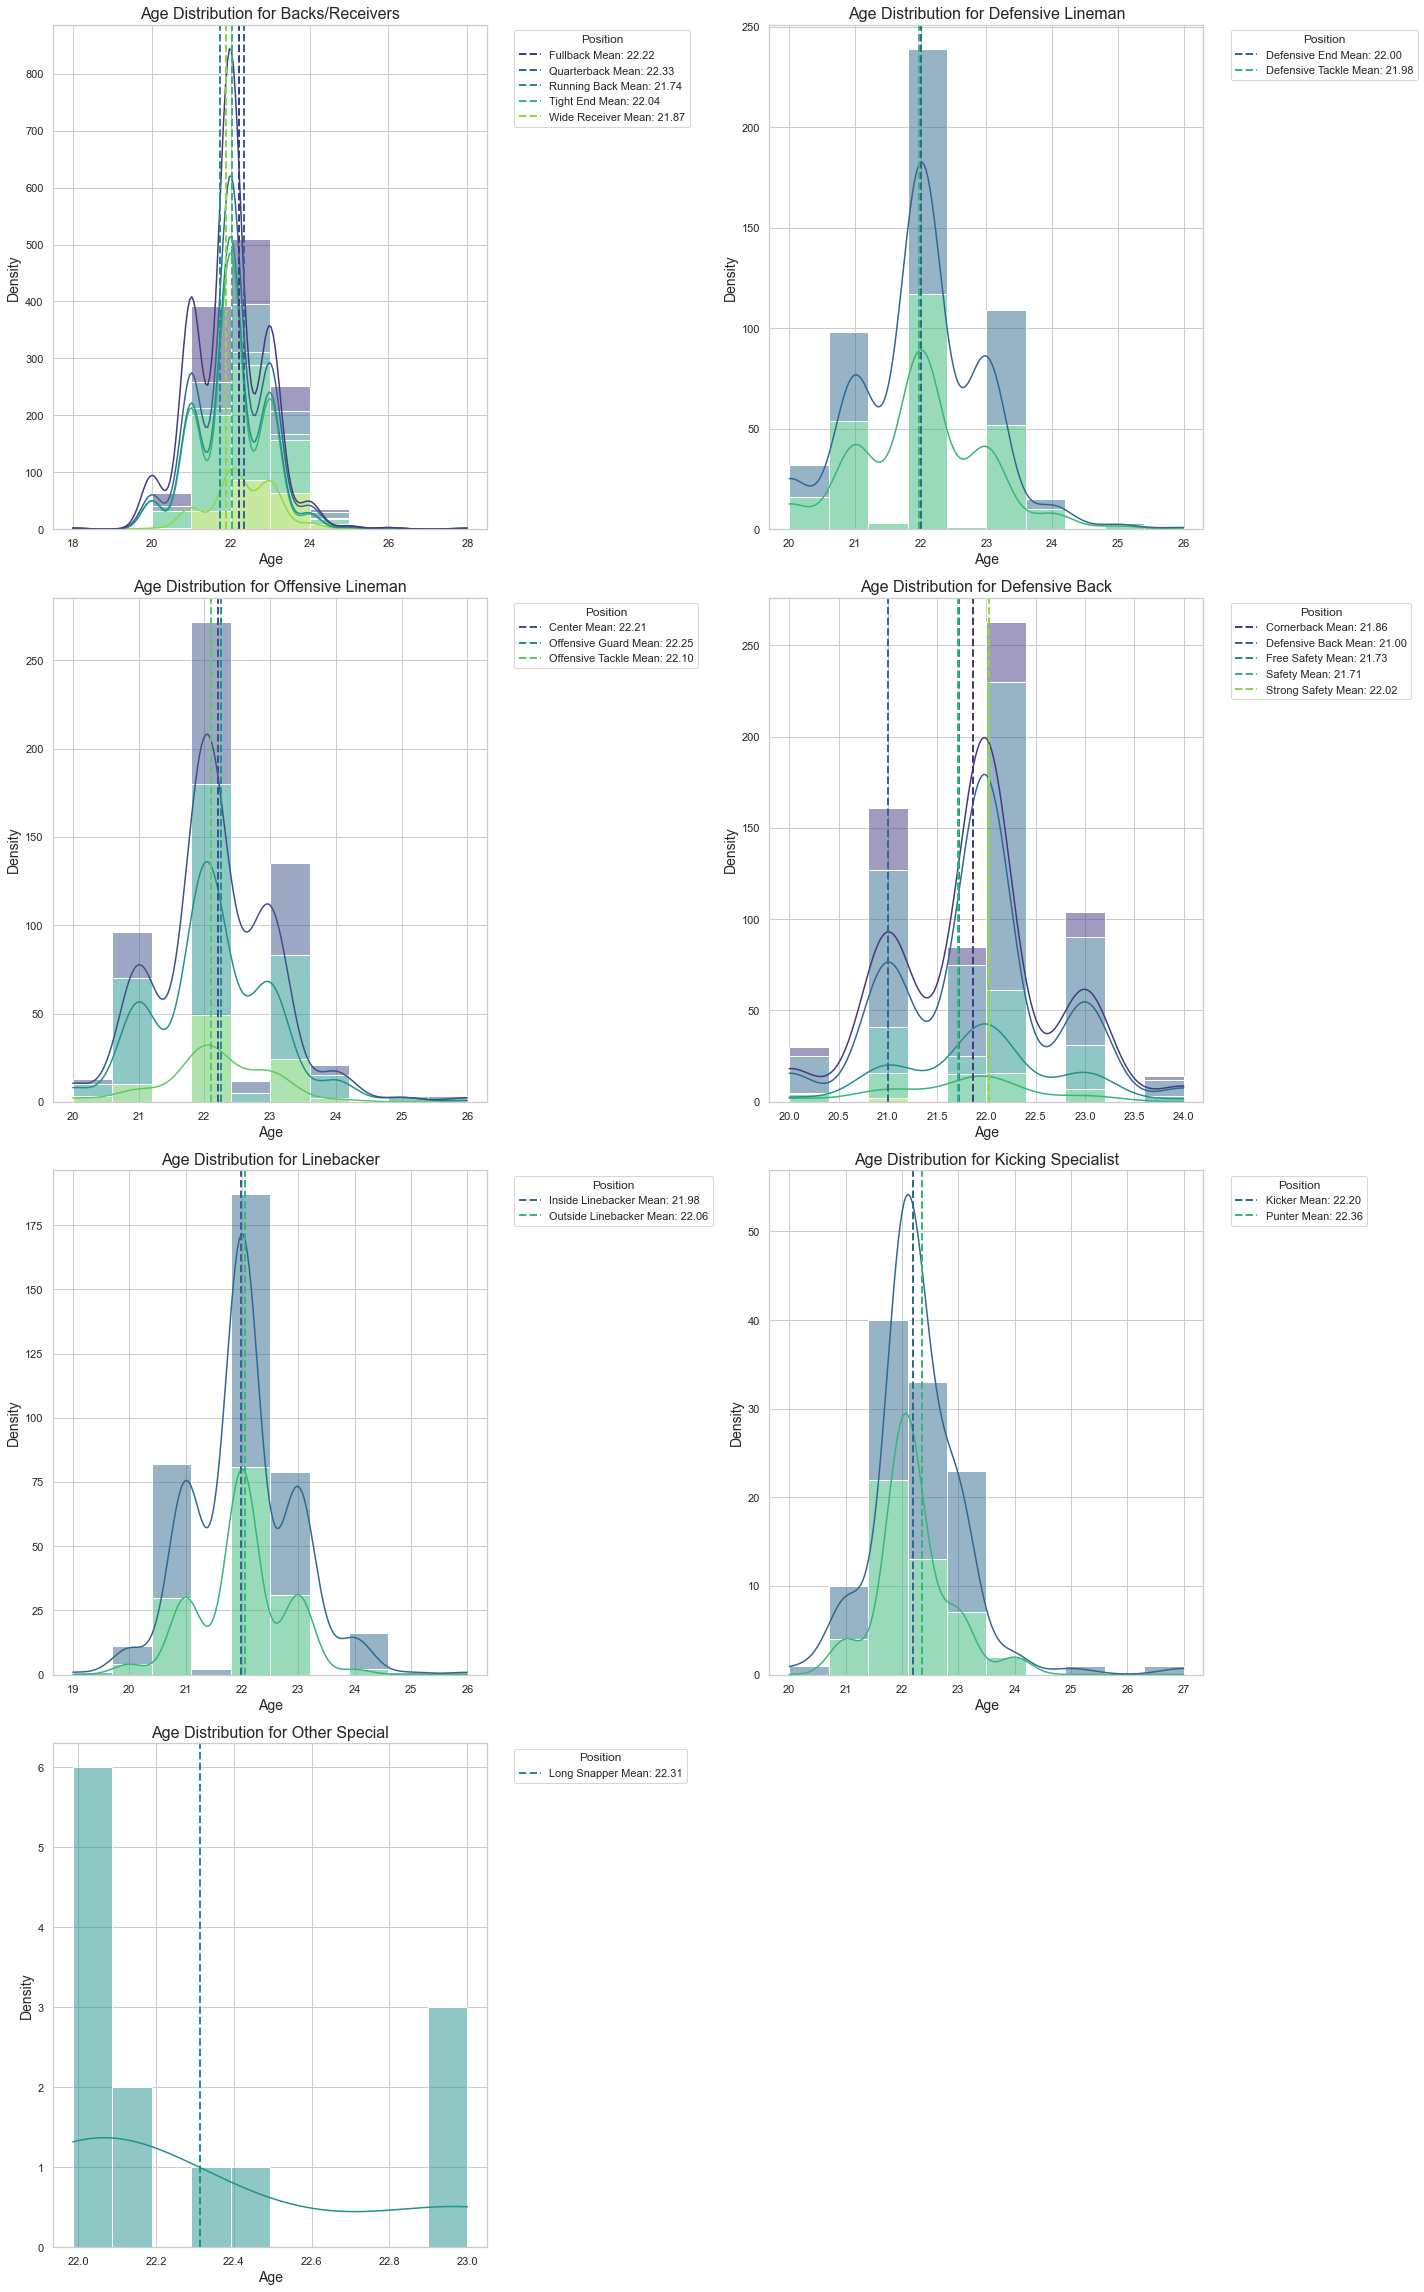

In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame

# Set the style for the plots
sns.set(style="whitegrid")

# Step 1: Get unique position types
position_types = df['Position_Type'].unique()
num_positions = len(position_types)

# Step 2: Set up the plot grid (2 plots per row)
plt.figure(figsize=(20, (num_positions // 2 + 1) * 8))

# Step 3: Loop through each Position_Type and create a distribution plot
for i, position_type in enumerate(position_types):
    plt.subplot((num_positions + 1) // 2, 2, i + 1)
    subset = df[df['Position_Type'] == position_type]
    
    # Plot the distribution of ages with hue based on Position
    sns.histplot(subset, x='Age', hue='Position', kde=True, bins=10, palette='viridis', multiple='stack')
    
    # Calculate and plot the mean age for each position
    mean_age = subset.groupby('Position')['Age'].mean()
    palette = sns.color_palette('viridis', n_colors=len(mean_age))
    for j, (pos, mean) in enumerate(mean_age.items()):
        plt.axvline(mean, linestyle='dashed', linewidth=2, color=palette[j], label=f'{pos} Mean: {mean:.2f}')
    
    # Add title and labels
    plt.title(f'Age Distribution for {position_type}', fontsize=16)
    plt.xlabel('Age', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    
    # Add a legend in each plot
    plt.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to ensure it fits well
plt.tight_layout()
plt.show()


<b>Age column:</b> Filling missing values based on average age by position <br>
Except for DBs. All the positions have an average age of about 22 years old when entering the draft. Therefore, we fill

In [86]:
import pandas as pd
import numpy as np

# Assuming 'df' is your DataFrame

# Step 1: Calculate the mean age by position
mean_age_by_position = df.groupby('Position')['Age'].mean().round().reset_index()

# Step 2: Merge this mean age back into the original DataFrame
df = df.merge(mean_age_by_position, on='Position', suffixes=('', '_Position_Avg'))

# Step 3: Fill in the NAs in 'Age' with the corresponding 'Position_Avg' and round to the nearest integer
df['Age'] = df['Age'].fillna(df['Age_Position_Avg']).round()

# Step 4: Drop the 'Age_Position_Avg' column as it's no longer needed
df = df.drop(columns=['Age_Position_Avg'])


# Exploratory Data Analysis

### Correlation Analysis and Collinearity

<b> Correlation Between Numerical Variables:</b><br>
Despite shuttle missing 35% of its values, we are able to create weight classes and find the mean of each other variable for all other columns. To illustrate this, let's create a graph highlighting the mean shuttle for the different weight classes.; As highlighted by the graph: the strong relationship between shuttle time and weight is represented. The bigger the weight class, the higher the mean shuttle. The relevancy of this with regards to missing values is replacing missing values by the mean of the strata. For instance, if a player is between 160 and 167kg, then we replace the null shuttle value with the 4.95 shuttle. Despite the very high collinearity amongst numerical variables, we are still interested in retaining them since we want to see how each individual feature influences the probability of being drafted

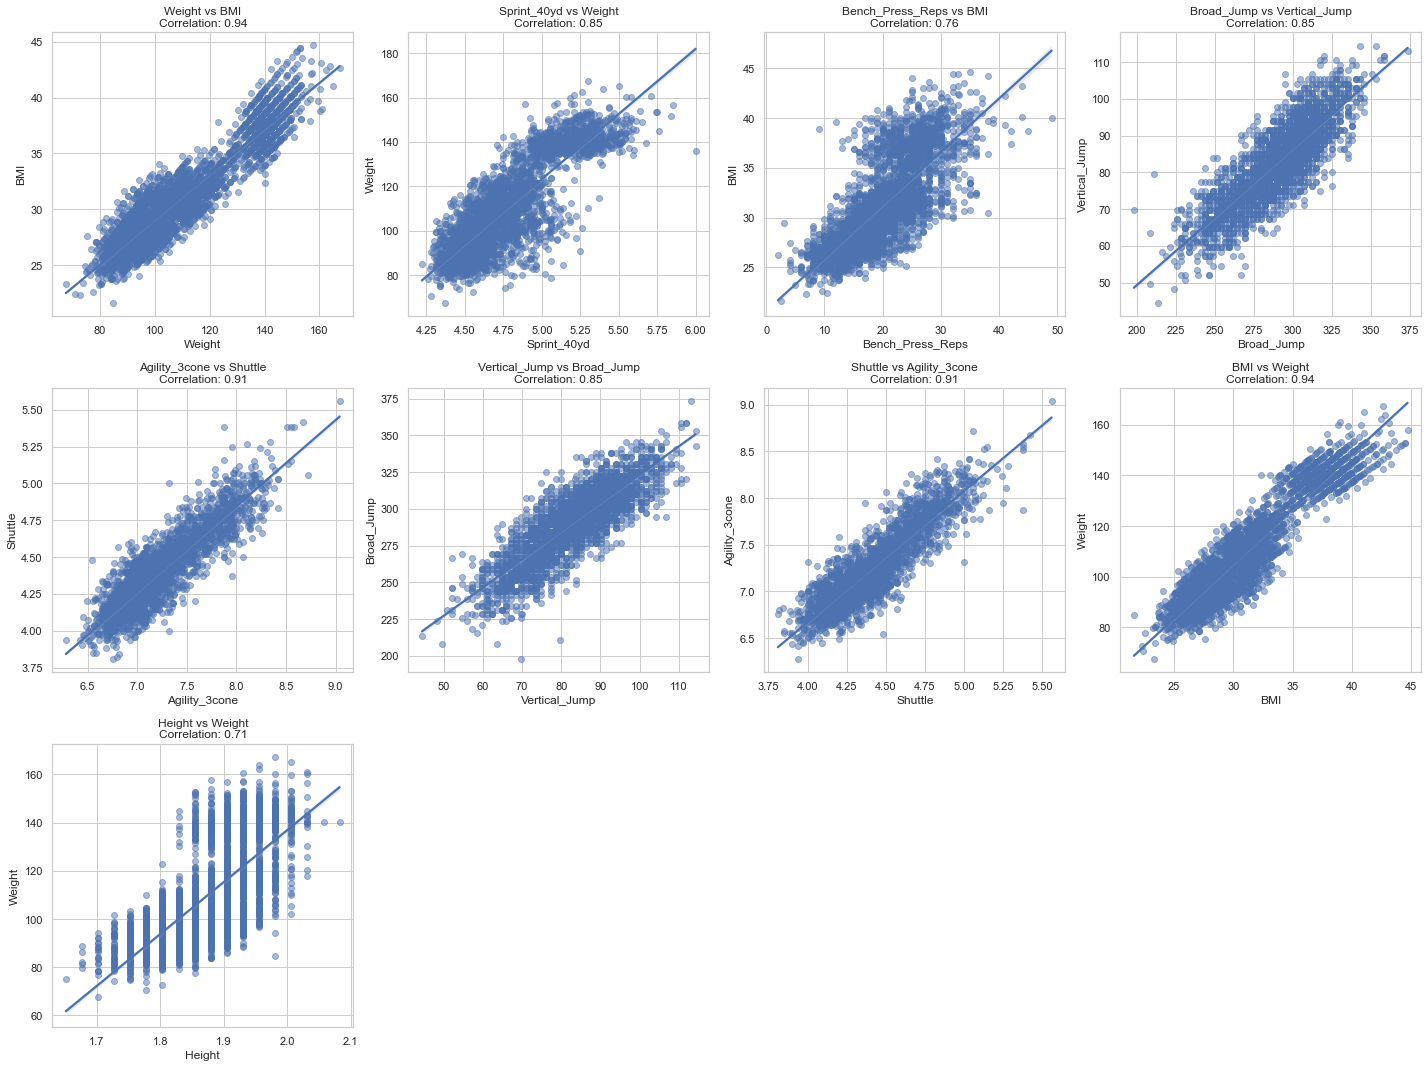

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it already contains one-hot encoded variables

# List of numerical columns
numerical_columns = ['Weight', 'Sprint_40yd', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', 'Vertical_Jump', 'Shuttle', 'BMI', 'Height']

# List of one-hot encoded columns (assuming they start with 'Position_' or 'Drafted_')
encoded_columns = [col for col in df.columns if col.startswith('Position') or col.startswith('Drafted_')]

# Combine numerical and encoded columns
all_columns = numerical_columns + encoded_columns

# Calculate the correlation matrix for the combined columns
correlation_matrix = df[all_columns].corr()

# Find the variable with the highest correlation for each variable
highest_correlation = {}
for col in correlation_matrix.columns:
    # Exclude self-correlation by setting it to NaN
    correlation_matrix.loc[col, col] = np.nan
    # Find the maximum correlation value and its corresponding variable
    max_corr_value = correlation_matrix[col].max()
    max_corr_var = correlation_matrix[col].idxmax()
    highest_correlation[col] = (max_corr_var, max_corr_value)

# Convert the result to a DataFrame for better visualization
highest_correlation_df = pd.DataFrame(highest_correlation, index=['Most Correlated Variable', 'Correlation Coefficient']).T

# Create a grid of reg plots (4 plots per row)
num_vars = len(highest_correlation_df)
fig, axes = plt.subplots((num_vars + 3) // 4, 4, figsize=(20, 15))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plotting each pair using regplot
for i, (var, row) in enumerate(highest_correlation_df.iterrows()):
    most_corr_var = row['Most Correlated Variable']
    sns.regplot(data=df, x=var, y=most_corr_var, ax=axes[i], scatter_kws={'alpha': 0.5})
    axes[i].set_title(f'{var} vs {most_corr_var}\nCorrelation: {row["Correlation Coefficient"]:.2f}')
    axes[i].grid(True)

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


<b> Relationship between Numerical and Categorical Variables </b>

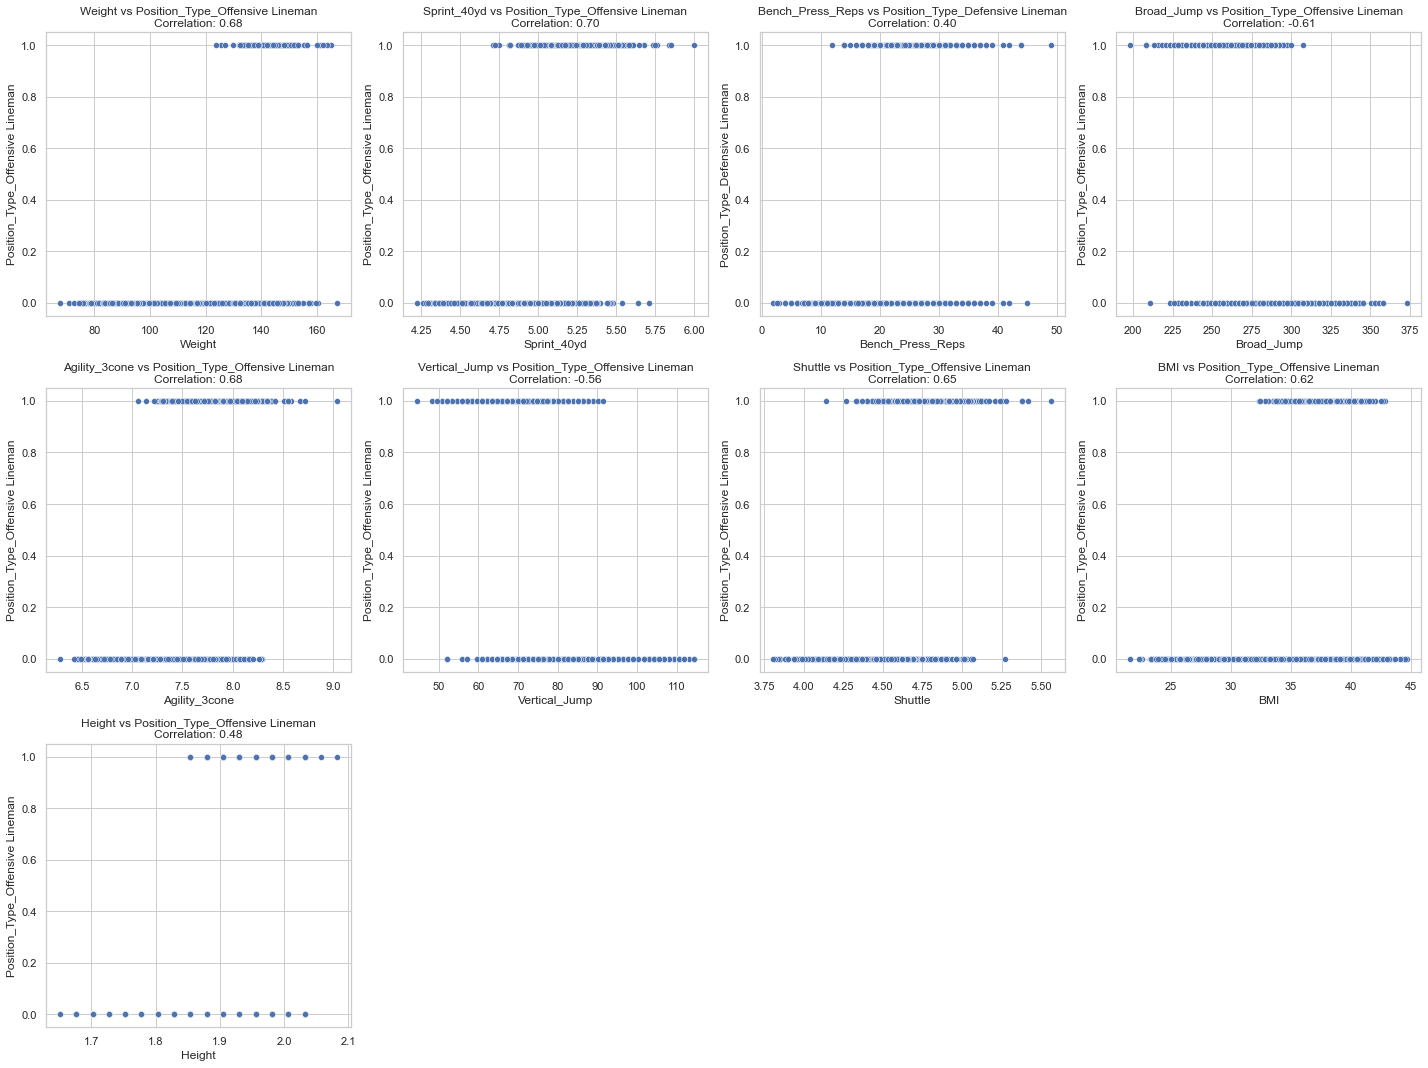

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame

# Select the relevant columns including categorical ones
df_encoded = df.loc[:, ['Weight', 'Sprint_40yd', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', 'Vertical_Jump', 'Shuttle', 'BMI', 'Height', 'Drafted', 'Position_Type']]

# One-hot encode the categorical variables
df_encoded = pd.get_dummies(df_encoded, columns=['Drafted', 'Position_Type'])

# Calculate the correlation matrix
correlation_matrix = df_encoded.corr()

# Filter for correlations between numerical and one-hot encoded variables
# Extracting correlations for the numerical variables with any "Drafted_" or "Position_" variables
numerical_columns = ['Weight', 'Sprint_40yd', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', 'Vertical_Jump', 'Shuttle', 'BMI', 'Height']
encoded_columns = [col for col in df_encoded.columns if col.startswith('Drafted_') or col.startswith('Position_')]

# Find the highest correlation for each numerical variable with any one-hot encoded variable
highest_correlation = {}
for num_col in numerical_columns:
    max_corr_value = None
    max_corr_var = None
    for enc_col in encoded_columns:
        corr_value = correlation_matrix.loc[num_col, enc_col]
        if max_corr_value is None or abs(corr_value) > abs(max_corr_value):
            max_corr_value = corr_value
            max_corr_var = enc_col
    highest_correlation[num_col] = (max_corr_var, max_corr_value)

# Convert the result to a DataFrame for better visualization
highest_correlation_df = pd.DataFrame(highest_correlation, index=['Most Correlated Variable', 'Correlation Coefficient']).T

# Create a grid of plots (4 plots per row)
num_vars = len(highest_correlation_df)
fig, axes = plt.subplots((num_vars + 3) // 4, 4, figsize=(20, 15))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plotting each pair
for i, (var, row) in enumerate(highest_correlation_df.iterrows()):
    most_corr_var = row['Most Correlated Variable']
    sns.scatterplot(data=df_encoded, x=var, y=most_corr_var, ax=axes[i])
    axes[i].set_title(f'{var} vs {most_corr_var}\nCorrelation: {row["Correlation Coefficient"]:.2f}')
    axes[i].grid(True)

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


<b> Correlation Between Categorical variables using the chi-Square method </b>

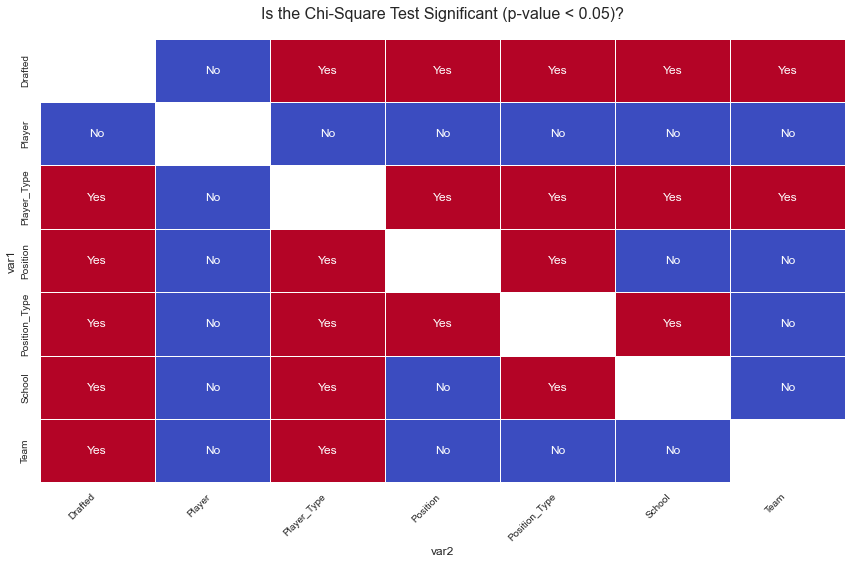

In [89]:
from itertools import product
import scipy.stats as ss
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Identify categorical variables
df_cat = pd.DataFrame(data=df.dtypes, columns=['dtype']).reset_index()
cat_var = list(df_cat['index'].loc[df_cat['dtype'] == 'object'])
df_cat_v1 = df[cat_var].dropna()

# Define pairs of categorical variables
cat_var1 = ('Player', 'School', 'Player_Type', 'Position_Type', 'Position', 'Drafted', 'Team')
cat_var2 = ('Player', 'School', 'Player_Type', 'Position_Type', 'Position', 'Drafted', 'Team')

# Generate all possible combinations between the variables
cat_var_prod = list(product(cat_var1, cat_var2, repeat=1))
result = []

# Perform Chi-Square test for each pair and store the p-values
for i in cat_var_prod:
    if i[0] != i[1]:
        # Compute the chi-squared test
        chi2, p, dof, ex = ss.chi2_contingency(pd.crosstab(df_cat_v1[i[0]], df_cat_v1[i[1]]))
        significance = 1 if p < 0.05 else 0  # Use numeric values 1 and 0
        result.append((i[0], i[1], p, significance))

# Convert the result to a DataFrame
chi_test_output = pd.DataFrame(result, columns=['var1', 'var2', 'p_value', 'Significant'])

# Pivot the results to create a matrix for the heatmap
chi_test_pivot = chi_test_output.pivot(index='var1', columns='var2', values='Significant')

# Create a corresponding annotation matrix with "Yes" or "No"
annotation_matrix = chi_test_pivot.applymap(lambda x: 'Yes' if x == 1 else 'No')

# Plot the heatmap using Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(chi_test_pivot, annot=annotation_matrix, cmap='coolwarm', cbar=False, linewidths=0.5, fmt='')

# Customize the heatmap
plt.title('Is the Chi-Square Test Significant (p-value < 0.05)?', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Display the heatmap
plt.show()


<b>Handling Multicollinearity :</b> <br><br>Numerical variables have strong collinearity. Despite that, we are interested in keeping them as they might be helpful in understanding, for each position, if a player is more likely to be drafted. Instead we will create composite score for similar drills

In [90]:
import pandas as pd

# Assuming 'df' is your DataFrame

# Normalize a column to a 0-1 scale
def normalize_column(df, column_name):
    return (df[column_name] - df[column_name].min()) / (df[column_name].max() - df[column_name].min())

# Create Strength Score
df['Strength_Score'] = normalize_column(df, 'Bench_Press_Reps')

# Create Jump Score by averaging the normalized Vertical Jump and Broad Jump
df['Jump_Score'] = (normalize_column(df, 'Vertical_Jump') + normalize_column(df, 'Broad_Jump')) / 2

# Create Agility & Speed Score by averaging the normalized Agility 3 cone, 40 yard sprint, and Shuttle
# For sprint times and agility, lower values are better, so we subtract the normalized values from 1
df['Agility_Speed_Score'] = (1 - normalize_column(df, 'Sprint_40yd') + 
                              1 - normalize_column(df, 'Agility_3cone') + 
                              1 - normalize_column(df, 'Shuttle')) / 3

df = df.drop(columns=['Sprint_40yd',
       'Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone',
       'Shuttle'])
# Display the first few rows to check the new columns
df.loc[:,["Strength_Score", "Agility_Speed_Score", "Jump_Score"]].head()


,Strength_Score,Agility_Speed_Score,Jump_Score
0,0.489362,0.768404,0.653228
1,0.531915,0.800351,0.691700
2,0.255319,0.808907,0.689855
3,0.404255,0.842156,0.676943
4,0.319149,0.745190,0.488274


### Metrics for Athleticism

#### <b> Composite Score</b>

In [91]:
import pandas as pd
import numpy as np

# Assuming 'df' is your DataFrame

# List of the columns to analyze
scores = ['Strength_Score', 'Jump_Score', 'Agility_Speed_Score']

# Calculate the composite score by averaging the selected columns
df['Composite_Score'] = df[scores].mean(axis=1)

# Display the first few rows of the DataFrame with the new 'Composite_Score' column
df["Composite_Score"]


0       0.636998
1       0.674655
2       0.584694
3       0.641118
4       0.517538
          ...   
3472    0.574856
3473    0.547421
3474    0.564969
3475    0.552519
3476    0.582170
Name: Composite_Score, Length: 3477, dtype: float64

#### <b>Position-Specific:</b> Athleticism

In [92]:
import pandas as pd

# Assuming 'df' is your DataFrame and 'Composite_Score_Player' is the column with composite scores

# Group by 'Position_Type' and calculate the mean of the 'Composite_Score_Player' for each position
position_composite_means = df.groupby('Position')['Composite_Score'].mean().reset_index()

# Sort the positions by their average composite score in descending order
position_composite_means = position_composite_means.sort_values(by='Composite_Score', ascending=False)

# Optional: Highlighting positions in the original DataFrame by merging the average composite score back to the original DataFrame
df = df.merge(position_composite_means, on='Position', suffixes=('', '_Position_Avg'))
# Display the first few rows to check the new column

#### <b>Position-Specific:</b> Strength Standard

In [93]:
import pandas as pd

# Group by 'Position_Type' and calculate the mean of the 'Composite_Score_Player' for each position
position_strength_means = df.groupby('Position')['Strength_Score'].mean().reset_index()

# Sort the positions by their average composite score in descending order
position_strength_means = position_strength_means.sort_values(by='Strength_Score', ascending=False)

df = df.merge(position_strength_means, on='Position', suffixes=('', '_Position_Avg'))


#### <b>Position Specific:</b> Speed/Agility Standards

* Find team with highest average athleticism based on the position specific

In [94]:
import pandas as pd

# Group by 'Position_Type' and calculate the mean of the 'Composite_Score_Player' for each position
position_agspeed_means = df.groupby('Position')['Agility_Speed_Score'].mean().reset_index()

# Sort the positions by their average composite score in descending order
position_agspeed_means = position_agspeed_means.sort_values(by='Agility_Speed_Score', ascending=False)

df = df.merge(position_agspeed_means, on='Position', suffixes=('', '_Position_Avg'))


#### <b>Position-Specific:</b> Jumping Standards

In [95]:
import pandas as pd

# Group by 'Position_Type' and calculate the mean of the 'Composite_Score_Player' for each position
position_jump_means = df.groupby('Position')['Jump_Score'].mean().reset_index()

# Sort the positions by their average composite score in descending order
position_jump_means = position_jump_means.sort_values(by='Jump_Score', ascending=False)
df = df.merge(position_jump_means, on='Position', suffixes=('', '_Position_Avg'))


### Performance by Position Standards

#### <b> Metric of Skill by Position</b>

In [96]:
import pandas as pd

# Assuming 'df' is your DataFrame

# Group by 'Position' and calculate the mean for each score category
position_means = df.groupby('Position').agg({
    'Strength_Score': 'mean',
    'Jump_Score': 'mean',
    'Agility_Speed_Score': 'mean'
}).reset_index()

# Determine the strongest feat for each position
def determine_strongest_feat(row):
    feats = {
        'Strength_Score': row['Strength_Score'],
        'Jump_Score': row['Jump_Score'],
        'Agility_Speed_Score': row['Agility_Speed_Score']
    }
    return max(feats, key=feats.get)

# Apply the function to each row to create a new column
position_means['Strongest_Feat_Position'] = position_means.apply(determine_strongest_feat, axis=1)

# Merge the 'Strongest_Feat' back into the original DataFrame
df = df.merge(position_means[['Position', 'Strongest_Feat_Position']], on='Position', how='left')



0    Agility_Speed_Score
1    Agility_Speed_Score
2    Agility_Speed_Score
3    Agility_Speed_Score
4    Agility_Speed_Score
Name: Strongest_Feat_Position, dtype: object

In [120]:
import pandas as pd

# Assuming 'df' is your DataFrame

# Group by 'Position' and calculate the mean for each score category
position_means = df.groupby('Position_Type').agg({
    'Strength_Score': 'mean',
    'Jump_Score': 'mean',
    'Agility_Speed_Score': 'mean'
}).reset_index()

# Determine the strongest feat for each position
def determine_strongest_feat(row):
    feats = {
        'Strength_Score': row['Strength_Score'],
        'Jump_Score': row['Jump_Score'],
        'Agility_Speed_Score': row['Agility_Speed_Score']
    }
    return max(feats, key=feats.get)

# Apply the function to each row to create a new column
position_means['Strongest_Feat_Position_Type'] = position_means.apply(determine_strongest_feat, axis=1)

# Merge the 'Strongest_Feat' back into the original DataFrame
df = df.merge(position_means[['Position_Type', 'Strongest_Feat_Position_Type']], on='Position_Type', how='left')



<b>Clustering Best Position Feat by Position </b>

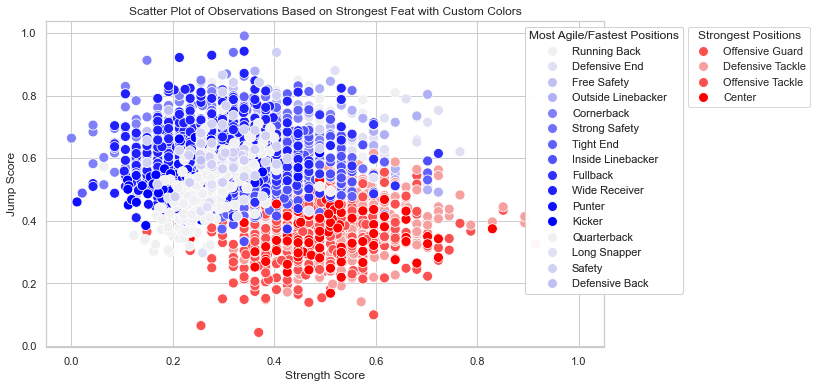

In [134]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the existing data and plot setup

# Step 1: Create a custom color palette
strength_colors = sns.light_palette("red", n_colors=len(df[df['Strongest_Feat_Position'] == 'Strength_Score']['Position'].unique()))
agility_colors = sns.light_palette("blue", n_colors=len(df[df['Strongest_Feat_Position'] == 'Agility_Speed_Score']['Position'].unique()))

# Create a dictionary for the colors
color_mapping = {}
for i, position in enumerate(df['Position'].unique()):
    if df.loc[df['Position'] == position, 'Strongest_Feat_Position'].iloc[0] == 'Strength_Score':
        color_mapping[position] = strength_colors[i % len(strength_colors)]
    elif df.loc[df['Position'] == position, 'Strongest_Feat_Position'].iloc[0] == 'Agility_Speed_Score':
        color_mapping[position] = agility_colors[i % len(agility_colors)]

df_plot = df
# Map colors to the DataFrame
df_plot['Color'] = df_plot['Position'].map(color_mapping)

# Step 2: Create a scatter plot to visualize the clusters based on the strongest feat
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    x='Strength_Score', 
    y='Jump_Score', 
    hue='Position', 
    palette=color_mapping, 
    data=df_plot, 
    s=100,
    legend=False  # Disable the default legend
)

# Step 3: Manually create the legend for Strength
strength_positions = df_plot[df_plot['Strongest_Feat_Position'] == 'Strength_Score']['Position'].unique()
handles_strength = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[pos], markersize=10, label=pos) 
                    for pos in strength_positions]
legend_strength = ax.legend(handles=handles_strength, title='Strength Feat', loc='upper center', bbox_to_anchor=(1.3, 1))

# Step 4: Manually create the legend for Agility/Speed
agility_positions = df_plot[df_plot['Strongest_Feat_Position'] == 'Agility_Speed_Score']['Position'].unique()
handles_agility = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[pos], markersize=10, label=pos) 
                   for pos in agility_positions]
# Add the first legend for Strength Feat
legend_strength = ax.legend(handles=handles_strength, title='Strongest Positions', loc='upper center', bbox_to_anchor=(1.26, 1))

# Add the second legend for Agility/Speed Feat, placing it right next to the first legend
# The x-coordinate of bbox_to_anchor for the second legend should be adjusted
# The adjustment depends on the size of the first legend, you might need to tweak it
legend_agility = ax.legend(handles=handles_agility, title='Most Agile/Fastest Positions', loc='upper center', bbox_to_anchor=(1.0, 1))

# Add both legends to the plot
ax.add_artist(legend_strength)
ax.add_artist(legend_agility)

# Customize the plot
plt.title('Scatter Plot of Observations Based on Strongest Feat with Custom Colors')
plt.xlabel('Strength Score')
plt.ylabel('Jump Score')
plt.grid(True)
plt.show()

#### <b> Most Skilled Players by Position Standards:</b> Strongest Position Feat

In [136]:
# First look at the strongest feat position column for a player
# Then look at the column related to that feat. Like if a player's position best feat is Agilty_Speed_Score, check the 
# Agility_Speed_Score_Position_Avg for the given position, check the player's Agility_Speed_Score for the position
# Then, if the player's Agility_Speed_Score is above the Agility_Speed_Score_Position_Avg, create a new column for the position Standard
# and add "Above Average Position Standard", if under, "Below Average Position Standard"

# For each player, compare their score in the strongest feat to the position's average score
def compare_to_position_standard(row):
    # Determine the strongest feat for the player's position
    strongest_feat = row['Strongest_Feat_Position']
    
    # Compare the player's score in the strongest feat to the position's average score
    player_score = row[strongest_feat]
    position_avg_score = row[f'{strongest_feat}_Position_Avg']

    if player_score > position_avg_score:
        return "Above Average Position Standard"
    else:
        return "Below Average Position Standard"

# Apply the comparison function to create the 'Position_Standard' column
df['Position_Standard (Skill Specific)'] = df.apply(compare_to_position_standard, axis=1)

# Display the first few rows to check the new column

#### <b> Most Skilled Players by Position Standards:</b> Overall Athleticism

In [141]:
# Step 2: Compare the player's Composite_Score to the position's average Composite_Score
def compare_composite_to_position_standard(row):
    player_composite_score = row['Composite_Score']
    position_avg_composite_score = row['Composite_Score_Position_Avg']

    if player_composite_score > position_avg_composite_score:
        return "Above Average Position Standard (Overall Athleticism)"
    else:
        return "Below Average Position Standard (Overall Athleticism)"

# Apply the comparison function to create the 'Position Standard (Overall Athleticism)' column
df['Position Standard (Overall Athleticism)'] = df.apply(compare_composite_to_position_standard, axis=1)

# Display the first few rows to check the new column
df["Position Standard (Overall Athleticism)"].value_counts().head()

Below Average Position Standard (Overall Athleticism)    1779
Above Average Position Standard (Overall Athleticism)    1698
Name: Position Standard (Overall Athleticism), dtype: int64

### <b>Relative Metrics for Athleticism</b>

<b> Normalized Composite Score:</b> Relativeness of Player's overall a in relation to Composite Score Average for his position

In [142]:
# Step 3: Calculate the relative composite score for each player
df['Relative_Composite_Score'] = df['Composite_Score'] / df['Composite_Score_Position_Avg']

# Step 4: Normalize the relative composite scores to a range between 0 and 1
min_score = df['Relative_Composite_Score'].min()
max_score = df['Relative_Composite_Score'].max()

df['Normalized_Composite_Score'] = (df['Relative_Composite_Score'] - min_score) / (max_score - min_score)

<b> Normalized Skill-Specific Score:</b> Relativeness of Player skill-specific score in relation to skill-specific score Average for his position

In [146]:
# Step 3: Calculate the relative skill-specific scores for each player
df['Relative_Strength_Score'] = df['Strength_Score'] / df['Strength_Score_Position_Avg']
df['Relative_Jump_Score'] = df['Jump_Score'] / df['Jump_Score_Position_Avg']
df['Relative_Agility_Speed_Score'] = df['Agility_Speed_Score'] / df['Agility_Speed_Score_Position_Avg']

# Step 4: Normalize the relative skill-specific scores to a range between 0 and 1
min_strength_score = df['Relative_Strength_Score'].min()
max_strength_score = df['Relative_Strength_Score'].max()

min_jump_score = df['Relative_Jump_Score'].min()
max_jump_score = df['Relative_Jump_Score'].max()

min_agility_speed_score = df['Relative_Agility_Speed_Score'].min()
max_agility_speed_score = df['Relative_Agility_Speed_Score'].max()

df['Normalized_Strength_Score'] = (df['Relative_Strength_Score'] - min_strength_score) / (max_strength_score - min_strength_score)
df['Normalized_Jump_Score'] = (df['Relative_Jump_Score'] - min_jump_score) / (max_jump_score - min_jump_score)
df['Normalized_Agility_Speed_Score'] = (df['Relative_Agility_Speed_Score'] - min_agility_speed_score) / (max_agility_speed_score - min_agility_speed_score)

# Step 5: Display the first few rows to check the new columns
df[['Player', 'Position', 'Normalized_Strength_Score',
'Normalized_Jump_Score','Normalized_Agility_Speed_Score', 'Normalized_Composite_Score']].head()

,Player,Position,Normalized_Strength_Score,Normalized_Jump_Score,Normalized_Agility_Speed_Score,Normalized_Composite_Score
0,Beanie Wells,Running Back,0.598797,0.631968,0.656066,0.703155
1,Cedric Peerman,Running Back,0.650866,0.674255,0.683343,0.768742
2,Mike Goodson,Running Back,0.312416,0.672228,0.690648,0.612057
3,Bernard Scott,Running Back,0.494658,0.658035,0.719036,0.710331
4,James Davis,Running Back,0.390520,0.450651,0.636246,0.495091


Dropping irrelevant columns

In [2]:
"""
import pandas as pd

import pandas as pd

# Assuming 'df' is your DataFrame

# List of columns to drop
columns_to_drop = [
    'Relative_Composite_Score',
    'Relative_Strength_Score',
    'Relative_Jump_Score',
    'Relative_Agility_Speed_Score',
    'Composite_Score_Position_Avg',
    'Strength_Score_Position_Avg',
    'Agility_Speed_Score_Position_Avg',
    'Jump_Score_Position_Avg',
    'Strength_Score', 
    'Jump_Score', 
    'Agility_Speed_Score',
       'Composite_Score'
]

# Drop the specified columns
df_cleaned = df.drop(columns=columns_to_drop)

# Display the remaining columns
df_cleaned.columns
"""


"\nimport pandas as pd\n\nimport pandas as pd\n\n# Assuming 'df' is your DataFrame\n\n# List of columns to drop\ncolumns_to_drop = [\n    'Relative_Composite_Score',\n    'Relative_Strength_Score',\n    'Relative_Jump_Score',\n    'Relative_Agility_Speed_Score',\n    'Composite_Score_Position_Avg',\n    'Strength_Score_Position_Avg',\n    'Agility_Speed_Score_Position_Avg',\n    'Jump_Score_Position_Avg',\n    'Strength_Score', \n    'Jump_Score', \n    'Agility_Speed_Score',\n       'Composite_Score'\n]\n\n# Drop the specified columns\ndf_cleaned = df.drop(columns=columns_to_drop)\n\n# Display the remaining columns\ndf_cleaned.columns\n"

### Drafted Status based on Normalized Performance Standards

<b> Correlation:</b> Normalized Athletic Scores and Draft Status

In [147]:
# Step 2: Define a function to calculate correlations within a group
def calculate_correlations(group):
    # Select the relevant columns
    correlation_columns = ['Normalized_Composite_Score', 'Normalized_Strength_Score', 
                           'Normalized_Jump_Score', 'Normalized_Agility_Speed_Score', 'Drafted_Num']
    
    # Calculate the correlation matrix for the group
    correlation_matrix = group[correlation_columns].corr()
    
    # Extract the correlation with 'Drafted_Num'
    return correlation_matrix['Drafted_Num'].drop('Drafted_Num')
df_cleaned = df
df_cleaned['Drafted_Num'] = df_cleaned['Drafted'].apply(lambda x: 1 if x == 'Yes' else 0)
# Step 3: Group by 'Position' and calculate correlations
correlations_by_position = df_cleaned.groupby('Position').apply(calculate_correlations)

# Step 4: Separate the skill-specific and composite score correlations
skill_specific_columns = ['Normalized_Strength_Score', 'Normalized_Jump_Score', 'Normalized_Agility_Speed_Score']
composite_score_column = 'Normalized_Composite_Score'

# Identify the highest skill-specific correlation for each position
highest_skill_specific_correlation = correlations_by_position[skill_specific_columns].idxmax(axis=1)
max_skill_specific_value = correlations_by_position[skill_specific_columns].max(axis=1)

# Get the correlation for the composite score
composite_score_correlation = correlations_by_position[composite_score_column]

# Combine the results into a DataFrame
highlighted_correlations = pd.DataFrame({
    'Highest_Skill_Specific_Correlation': highest_skill_specific_correlation,
    'Highest_Skill_Specific_Value': max_skill_specific_value,
    'Composite_Score_Correlation': composite_score_correlation
})

# Display the highlighted correlations by position
highlighted_correlations

,Highest_Skill_Specific_Correlation,Highest_Skill_Specific_Value,Composite_Score_Correlation
Position,,,
Center,Normalized_Agility_Speed_Score,0.112814,0.035466
Cornerback,Normalized_Strength_Score,0.198061,0.273119
Defensive Back,Normalized_Agility_Speed_Score,1.000000,-1.000000
Defensive End,Normalized_Jump_Score,0.289495,0.339587
Defensive Tackle,Normalized_Strength_Score,0.185601,0.222111
Free Safety,Normalized_Agility_Speed_Score,0.321495,0.328732
Fullback,Normalized_Agility_Speed_Score,0.313676,0.373121
Inside Linebacker,Normalized_Agility_Speed_Score,0.340984,0.348382
Kicker,Normalized_Strength_Score,0.309498,0.308707


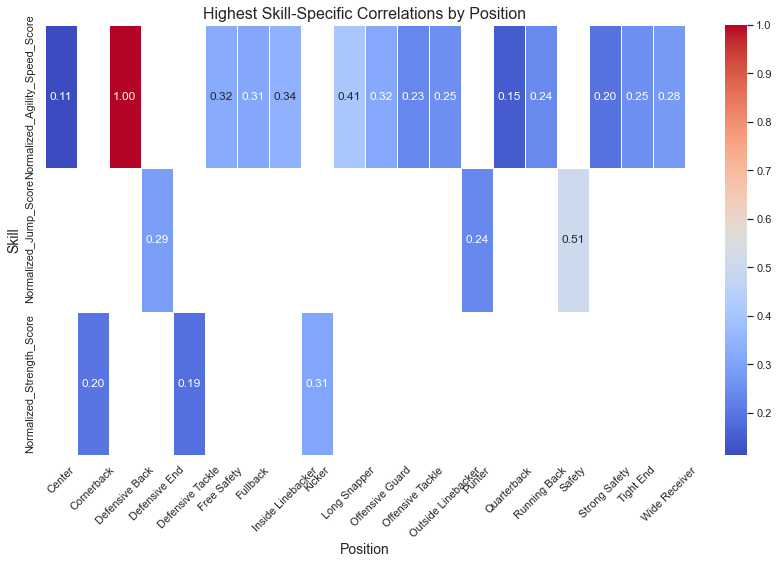

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have calculated the highlighted_correlations DataFrame

# Create a pivot table to structure data for the heatmap
heatmap_data = pd.pivot_table(highlighted_correlations, values='Highest_Skill_Specific_Value', 
                              index='Highest_Skill_Specific_Correlation', columns=highlighted_correlations.index)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=.5, fmt=".2f")

# Customize the plot
plt.title('Highest Skill-Specific Correlations by Position', fontsize=16)
plt.xlabel('Position', fontsize=14)
plt.ylabel('Skill', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<b>Outlier Analysis:</b> Correlation between Normalized Performance and being drafted

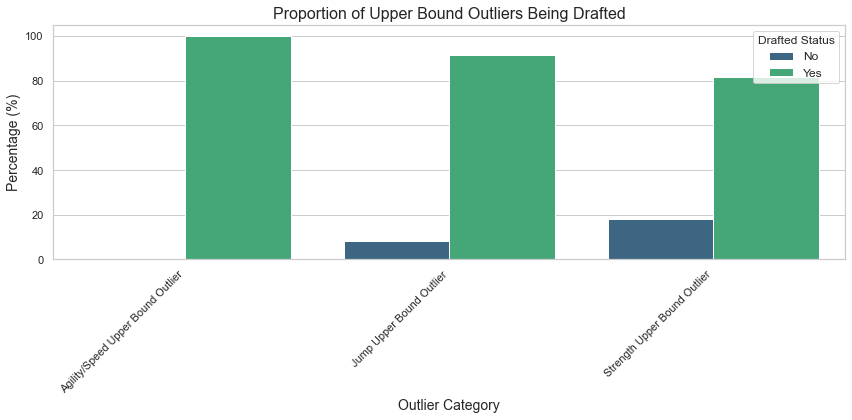

In [165]:
import pandas as pd
from scipy.stats import zscore

# Assuming 'temp_df' is your DataFrame and it contains relevant columns
temp_df = df
# Step 1: Calculate the z-scores for each position group
# Step 1: Calculate the z-scores for each position group
temp_df['Strength_Z'] = temp_df.groupby('Position')['Strength_Score'].transform(lambda x: zscore(x, nan_policy='omit'))
temp_df['Jump_Z'] = temp_df.groupby('Position')['Jump_Score'].transform(lambda x: zscore(x, nan_policy='omit'))
temp_df['Agility_Speed_Z'] = temp_df.groupby('Position')['Agility_Speed_Score'].transform(lambda x: zscore(x, nan_policy='omit'))

# Step 2: Create a category for upper bound outliers
def categorize_outlier(row):
    if row['Strength_Z'] >= 3:
        return 'Strength Upper Bound Outlier'
    elif row['Jump_Z'] >= 3:
        return 'Jump Upper Bound Outlier'
    elif row['Agility_Speed_Z'] >= 3:
        return 'Agility/Speed Upper Bound Outlier'
    else:
        return 'Not an Outlier'

temp_df['Outlier_Category'] = temp_df.apply(categorize_outlier, axis=1)

# Step 3: Filter the DataFrame to only include rows where the player is an outlier
outliers_df = temp_df[temp_df['Outlier_Category'] != 'Not an Outlier']

# Step 1: Calculate the proportion of drafted players within each outlier category
outlier_drafted_counts = outliers_df.groupby(['Outlier_Category', 'Drafted']).size().unstack(fill_value=0)

# Calculate the proportion of drafted players in each outlier category
outlier_drafted_proportion = outlier_drafted_counts.div(outlier_drafted_counts.sum(axis=1), axis=0) * 100

# Reset the index of the DataFrame for easier plotting
outlier_drafted_proportion = outlier_drafted_proportion.reset_index()

# Melt the DataFrame to make it suitable for seaborn
outlier_drafted_proportion_melted = outlier_drafted_proportion.melt(id_vars='Outlier_Category', value_vars=['No', 'Yes'], var_name='Drafted', value_name='Percentage')

# Create a bar plot with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='Outlier_Category', y='Percentage', hue='Drafted', data=outlier_drafted_proportion_melted, palette='viridis')

# Add titles and labels
plt.title('Proportion of Upper Bound Outliers Being Drafted', fontsize=16)
plt.xlabel('Outlier Category', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.legend(title='Drafted Status', loc='upper right', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


In [166]:
# Define a function to calculate correlations within a group
def calculate_correlations(group):
    # Select the relevant columns
    correlation_columns = ['Normalized_Composite_Score', 'Normalized_Strength_Score', 
                           'Normalized_Jump_Score', 'Normalized_Agility_Speed_Score', 'Drafted_Num']
    
    # Calculate the correlation matrix for the group
    correlation_matrix = group[correlation_columns].corr()
    
    # Extract the correlations with 'Drafted_Num'
    correlations = correlation_matrix['Drafted_Num'].drop('Drafted_Num')
    
    return correlations

# Group by 'Position' and calculate correlations
correlations_by_position = df_cleaned.groupby('Position').apply(calculate_correlations)

# Combine the results into a DataFrame
highlighted_correlations = pd.DataFrame({
    'Strength_Score_Correlation': correlations_by_position['Normalized_Strength_Score'],
    'Jump_Score_Correlation': correlations_by_position['Normalized_Jump_Score'],
    'Agility_Speed_Score_Correlation': correlations_by_position['Normalized_Agility_Speed_Score'],
    'Composite_Score_Correlation': correlations_by_position['Normalized_Composite_Score']
})

# Let's summarize the findings
summary = highlighted_correlations.describe()
summary


,Strength_Score_Correlation,Jump_Score_Correlation,Agility_Speed_Score_Correlation,Composite_Score_Correlation
count,20.000000,20.000000,20.000000,20.000000
mean,0.207117,0.151724,0.285514,0.215684
std,0.212124,0.286044,0.188783,0.305738
min,-0.074223,-1.000000,0.112814,-1.000000
25%,0.109653,0.157219,0.171551,0.215730
50%,0.187054,0.189945,0.253610,0.285188
75%,0.232548,0.239792,0.318244,0.333647
max,1.000000,0.507656,1.000000,0.566222


<b>Chi-Square Test:</b> Significance of Performance Metrics and drafted status

In [171]:
import pandas as pd
import scipy.stats as ss

# Assuming 'temp_df' is your DataFrame with relevant columns

# Step 1: Create the contingency table for the overall composite score (Above_Comp_Avg_Position)
contingency_table_comp_avg = pd.crosstab(df['Position Standard (Overall Athleticism)'], df['Drafted'])

# Display the contingency table for the overall composite score
print("Contingency Table for Composite Score Average:")
print(contingency_table_comp_avg)

# Step 2: Perform a Chi-Square test for the composite score average
chi2_comp_avg, p_comp_avg, dof_comp_avg, expected_comp_avg = ss.chi2_contingency(contingency_table_comp_avg)

# Display the results for the composite score average
print(f"\nChi-Square Test Statistic (Composite Score Average): {chi2_comp_avg}")
print(f"P-Value (Composite Score Average): {p_comp_avg}")

# Interpretation for composite score average
if p_comp_avg < 0.05:
    print("\nThere is a significant correlation between having an above average overall composite score and the probability of being drafted.")
else:
    print("\nThere is no significant correlation between having a higher overall composite score and the probability of being drafted.")

# Step 3: Create the contingency table for the skill-specific composite score (Above_Skill_Comp_Avg_Position)
contingency_table_skill_avg = pd.crosstab(df['Position_Standard (Skill Specific)'], df['Drafted'])

# Display the contingency table for the skill-specific composite score
print("\nContingency Table for Skill-Specific Composite Score:")
print(contingency_table_skill_avg)

# Step 4: Perform a Chi-Square test for the skill-specific composite score
chi2_skill_avg, p_skill_avg, dof_skill_avg, expected_skill_avg = ss.chi2_contingency(contingency_table_skill_avg)

# Display the results for the skill-specific composite score
print(f"\nChi-Square Test Statistic (Skill-Specific Composite Score): {chi2_skill_avg}")
print(f"P-Value (Skill-Specific Composite Score): {p_skill_avg}")

# Interpretation for skill-specific composite score
if p_skill_avg < 0.05:
    print("\nThere is a significant correlation between having an above average skill-specific composite score and the probability of being drafted.")
else:
    print("\nThere is no significant correlation between having a higher skill-specific composite score and the probability of being drafted.")


Contingency Table for Composite Score Average:
Drafted                                              No   Yes
Position Standard (Overall Athleticism)                      
Above Average Position Standard (Overall Athlet...  424  1274
Below Average Position Standard (Overall Athlet...  799   980

Chi-Square Test Statistic (Composite Score Average): 150.65340672689223
P-Value (Composite Score Average): 1.2477930837202126e-34

There is a significant correlation between having an above average overall composite score and the probability of being drafted.

Contingency Table for Skill-Specific Composite Score:
Drafted                              No   Yes
Position_Standard (Skill Specific)           
Above Average Position Standard     468  1253
Below Average Position Standard     755  1001

Chi-Square Test Statistic (Skill-Specific Composite Score): 94.48945245100087
P-Value (Skill-Specific Composite Score): 2.464018538624274e-22

There is a significant correlation between having an above av

<b> Best Players by Position Metrics:</b> Drafted Status

In [172]:
# Step 3: For each position, find the player with the highest score in the strongest feat
def get_max_player_for_position(group):
    strongest_feat = group['Strongest_Feat_Position'].iloc[0]
    return group.loc[group[strongest_feat].idxmax()]

top_players = df.groupby('Position').apply(get_max_player_for_position).reset_index(drop=True)

# Step 4: Highlight whether the player got drafted or not
top_players['Draft_Status'] = top_players['Drafted'].apply(lambda x: 'Drafted' if x == 'Yes' else 'Not Drafted')

# Step 5: Select and order the relevant columns for display
highlighted_df = top_players[['Position', 'Player', 'Strongest_Feat_Position', 'Draft_Status', 'Strength_Score', 'Jump_Score', 'Agility_Speed_Score', 'Composite_Score']]

# Display the final DataFrame
highlighted_df

,Position,Player,Strongest_Feat_Position,Draft_Status,Strength_Score,Jump_Score,Agility_Speed_Score,Composite_Score
0,Center,David Molk,Strength_Score,Drafted,0.829787,0.374669,0.486804,0.563753
1,Cornerback,Buster Skrine,Agility_Speed_Score,Drafted,0.382979,0.673386,0.935444,0.663936
2,Defensive Back,Minkah Fitzpatrick,Agility_Speed_Score,Drafted,0.255319,0.593412,0.808827,0.552519
3,Defensive End,Jordan Willis,Agility_Speed_Score,Drafted,0.468085,0.731489,0.783583,0.661052
4,Defensive Tackle,Stephen Paea,Strength_Score,Drafted,1.000000,0.441222,0.522274,0.654499
5,Free Safety,Justin Simmons,Agility_Speed_Score,Drafted,0.297872,0.756917,0.883115,0.645968
6,Fullback,Drake Dunsmore,Agility_Speed_Score,Drafted,0.404255,0.609881,0.826968,0.613702
7,Inside Linebacker,Ben Heeney,Agility_Speed_Score,Drafted,0.361702,0.595257,0.846212,0.601057
8,Kicker,Brett Swenson,Agility_Speed_Score,Not Drafted,0.212766,0.661714,0.842935,0.572472
9,Long Snapper,Jake Ingram,Agility_Speed_Score,Drafted,0.276596,0.507414,0.667168,0.483726


<b> Best Players by Overall Athleticism:</b> Drafted Status

In [173]:
import pandas as pd

# Assuming 'df' is your DataFrame and it already contains the 'Composite_Score' and 'Drafted' columns

# Step 1: For each position, find the player with the highest overall composite score
def get_max_composite_score_player(group):
    return group.loc[group['Composite_Score'].idxmax()]

top_players = df.groupby('Position').apply(get_max_composite_score_player).reset_index(drop=True)

# Step 2: Highlight whether the player got drafted or not
top_players['Draft_Status'] = top_players['Drafted'].apply(lambda x: 'Drafted' if x == 'Yes' else 'Not Drafted')

# Step 3: Select and order the relevant columns for display
highlighted_df = top_players[['Position', 'Player', 'Draft_Status', 'Composite_Score', 'Strength_Score', 'Jump_Score', 'Agility_Speed_Score']]

# Display the final DataFrame
highlighted_df


,Position,Player,Draft_Status,Composite_Score,Strength_Score,Jump_Score,Agility_Speed_Score
0,Center,David Molk,Drafted,0.563753,0.829787,0.374669,0.486804
1,Cornerback,Byron Jones,Drafted,0.735738,0.340780,0.990909,0.875526
2,Defensive Back,Quenton Meeks,Not Drafted,0.582170,0.191489,0.753228,0.801794
3,Defensive End,Cornelius Washington,Drafted,0.722970,0.723404,0.753228,0.692279
4,Defensive Tackle,Mike Martin,Drafted,0.655203,0.723404,0.544532,0.697673
5,Free Safety,Taylor Mays,Drafted,0.678442,0.468085,0.767852,0.799388
6,Fullback,Dan Vitale,Drafted,0.690664,0.595745,0.707905,0.768342
7,Inside Linebacker,Luke Kuechly,Drafted,0.675657,0.531915,0.698814,0.796242
8,Kicker,David Buehler,Drafted,0.617212,0.489362,0.617373,0.744901
9,Long Snapper,Joe Cardona,Drafted,0.593023,0.595745,0.537225,0.646099


### Summary Statistics: Who is the Best?

Using the normalized score, we find how good players in each entity based on their position specific skill. We find the highest average by entity, and sort by the highest

<b> Best Player</b>

<b> Best Round</b>

In [ ]:
import pandas as pd

# Assuming 'df' is your DataFrame and already contains the 'Composite_Score' column

# List of the columns to analyze
columns_to_analyze = ['Strength_Score', 'Jump_Score', 'Agility_Speed_Score']

# Group by 'Round' and calculate the mean for each of the selected columns
round_means = df.groupby('Round')[columns_to_analyze + ['Composite_Score']].mean()

# Find the round with the highest mean composite score
highest_mean_composite_score_round = round_means['Composite_Score'].idxmax()
highest_mean_composite_score_value = round_means['Composite_Score'].max()

# Create a DataFrame to display all rounds and their mean scores
round_scores_df = round_means.reset_index()

# Add a column to indicate the round with the highest composite score
round_scores_df['Highest_Score'] = round_scores_df['Round'].apply(
    lambda x: 'Highest' if x == highest_mean_composite_score_round else '')

# Sort the DataFrame by the composite score in descending order
round_scores_df = round_scores_df.sort_values(by='Composite_Score', ascending=False)

# Display the DataFrame with all rounds and their scores
print(f"Round with the Highest Mean Composite Score for Any Position: {highest_mean_composite_score_round}")
print(f"Highest Mean Composite Score: {highest_mean_composite_score_value:.2f}")

round_scores_df.head(10)  # Display the top 10 rounds


Round with the Highest Mean Composite Score for Any Position: 1
Highest Mean Composite Score: 0.56


,Round,Strength_Score,Jump_Score,Agility_Speed_Score,Composite_Score,Highest_Score
0,1,0.412200,0.572637,0.690541,0.558459,Highest
1,2,0.399558,0.565463,0.682097,0.549039,
3,4,0.383898,0.561896,0.690986,0.545593,
2,3,0.394050,0.554192,0.676556,0.541599,
4,5,0.379739,0.538994,0.678892,0.532542,
5,6,0.371907,0.539552,0.678687,0.530049,
6,7,0.388300,0.530913,0.663062,0.527425,
7,8,0.344754,0.522303,0.662940,0.509999,


<b> Best Team</b>

<b> Best School</b>

<b> Most sought after Position Type: </b> Looking at each round, we find that defensive linemen tend to be drafted in the first rounds. Out of all the drafted players in the defensive linemen positions, more than 50% will be picked by the 3rd round. In comparison, kicking specialists will exceed 50% at the 7th round. 

In [ ]:
import pandas as pd

# Initialize an empty list to store the data for each round
data = []

for i in range(1, 8):
    # Filter the DataFrame for players drafted in the current round
    round_df = df[df['Round'] == i]

    # Count the number of occurrences of each position in the current round
    position_counts_round = round_df['Position_Type'].value_counts()

    # Filter the DataFrame for drafted players
    drafted_players = df[df['Drafted'] == "Yes"]

    # Count the number of occurrences of each position for drafted players
    position_counts = drafted_players['Position_Type'].value_counts()

    # Calculate the percentage of each position in the current round relative to all drafted players
    percentage_total_position_round = position_counts_round / position_counts * 100

    # Fill NaN values with 0
    percentage_total_position_round = percentage_total_position_round.fillna(0)

    # Convert the Series to a DataFrame and add the round information
    round_data = percentage_total_position_round.reset_index()
    round_data.columns = ['Position_Type', f'Round_{i}_Percentage']
    
    # Append to the list
    data.append(round_data)

# Merge all the rounds' data into a single DataFrame
result_df = pd.concat(data, axis=1)

# Remove duplicate columns
result_df = result_df.loc[:,~result_df.columns.duplicated()]

# Display the DataFrame
result_df


,Position_Type,Round_1_Percentage,Round_2_Percentage,Round_3_Percentage,Round_4_Percentage,Round_5_Percentage,Round_6_Percentage,Round_7_Percentage
0,Backs/Receivers,13.246753,13.116883,15.324675,17.792208,13.766234,14.285714,12.467532
1,Defensive Back,13.932584,16.179775,16.404494,15.955056,16.853933,11.910112,8.764045
2,Defensive Lineman,18.681319,16.208791,19.780220,11.813187,9.890110,10.928962,13.186813
3,Kicking Specialist,0.000000,3.125000,3.125000,6.250000,50.000000,10.439560,15.625000
4,Linebacker,12.454212,15.384615,13.186813,18.681319,16.483516,12.087912,11.721612
5,Offensive Lineman,17.213115,14.480874,16.666667,14.207650,15.846995,21.875000,10.655738
6,Other Special,0.000000,0.000000,0.000000,0.000000,25.000000,75.000000,0.000000


### Summary Statistics: Who is the Worst?

Worst Player

Worst Team

Worst School

# Other analysis to review

We find that the majority of players get drafted, "With" 65% of the values in the "Drafted" column being "Yes"

In [ ]:
perc_drafted = len(df[df["Drafted"] == "Yes"]) / len(df) * 100
print("Percentage of drafted players:", perc_drafted)

We can also identify the proportion of players being drafted for each school:

In [ ]:
c = df.groupby(["School", "Drafted"]).size().unstack()
c[np.isnan(c)] = 0
c = c.divide(c.sum(1), axis=0)
c

Out of 253 schools, we find that 47 of them had a very successful draft, with 100% of their players being drafted

In [ ]:
filtered_df = c[c['No'] == 0.0].sum()
filtered_df

Out of 253 schools, 48 of them had 0% of their players being drafted

In [ ]:
filtered_df = c[c['Yes'] == 0.0].sum()
filtered_df

We find that more schools present in our data have a majority of players being accepted to the draft: 145 schools with more than 50% of their prospects being drafted, and 82 having the most of their prospects being rejected from the draft. This seems to indicate that most of the schools will have a successful draft.

In [ ]:
highlighted_df = c[c['Yes'] > c['No']]
highlighted_df

In [ ]:
highlighted_df = c[c['Yes'] < c['No']]
highlighted_df

These results do not necesarily take into account the number of players being drafted. For instance, a school could only have 1 players presenting for the draft and be accepted, which will be accounted as 100% of the school's players being drafted. Let's compare these results with school having 3 or more players per school.

In [ ]:
c = df.groupby(["School", "Player"]).size().reset_index()

# Count the number of players per school
player_counts = c["School"].value_counts()

# Filter schools that have 10 or more players
schools_with_10_or_more = player_counts[player_counts >= 3]

# Filter the original dataframe to only include these schools
filtered_df = df[df["School"].isin(schools_with_10_or_more.index)]

# Display the filtered dataframe
c = filtered_df.groupby(["School", "Drafted"]).size().unstack()
c[np.isnan(c)] = 0
c = c.divide(c.sum(1), axis=0)

When only taking account schools with 3 players or more, we find a drastic reduction of schools with either: 100% of players being drafted, or 100% of the players getting rejected from the draft. Only 6 Schools with 3 players or more presenting for the draft will have 100% of their players accepted, and only 4 schools with 3 players or more will have all their players rejected from the draft.

In [ ]:
filtered_df = c[c['No'] == 0.0].sum()
filtered_df

In [ ]:
filtered_df = c[c['Yes'] == 0.0].sum()
filtered_df

This brings us to inspect the schools with the highest number of players getting drafted, and the proportion of drafted players for each respective school. We find that schools with the highest number of players considered for the draft, have a high proportion of players being drafted.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group the data by 'School' and 'Drafted' and get the count
Drafted_players_by_school = df.groupby(['School', 'Drafted']).size().reset_index(name='count')

# Get the top 5 schools based on the count of 'Yes'
top_schools = Drafted_players_by_school[
    Drafted_players_by_school['Drafted'] == 'Yes'
].sort_values(by='count', ascending=False)[:8]['School']

# Filter the original data to include only the top 5 schools
top_schools_data = Drafted_players_by_school[
    Drafted_players_by_school['School'].isin(top_schools)
]

# Pivot the data to have 'Yes' and 'No' in separate columns
pivot_data = top_schools_data.pivot(index='School', columns='Drafted', values='count').fillna(0)

# Calculate totals and percentages
pivot_data['Total'] = pivot_data.sum(axis=1)
pivot_data['Yes%'] = (pivot_data['Yes'] / pivot_data['Total']) * 100
pivot_data['No%'] = (pivot_data['No'] / pivot_data['Total']) * 100

# Plotting
ax = pivot_data[['Yes', 'No']].plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(10, 6))

# Adding percentage annotations
for i in range(pivot_data.shape[0]):
    yes_count = pivot_data['Yes'].iloc[i]
    no_count = pivot_data['No'].iloc[i]
    total_count = pivot_data['Total'].iloc[i]
    
    yes_percent = pivot_data['Yes%'].iloc[i]
    no_percent = pivot_data['No%'].iloc[i]
    
    # Yes percentage on the orange part
    ax.text(i, no_count / 2, f'{yes_percent:.1f}%', ha='center', va='center', color='black', weight='bold')
    
    # No percentage on the blue part
    ax.text(i, yes_count + no_count / 2, f'{no_percent:.1f}%', ha='center', va='center', color='black', weight='bold')

# Customizing the plot
plt.title('Drafted Players by School (Top 8 Schools)', fontsize=16)
plt.ylabel('Number of Players', fontsize=14)
plt.xlabel('School', fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)

# Move the legend outside the plot
plt.legend(title="Drafted", loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout
plt.tight_layout()

plt.show()


Let's identify the schools with the highest average stats for their players. Since some schools only had 1-2 players presenting for the draft, the average mean stat for the drill might not be an accurate indication of whether the school has pre-dispositions for players being drafted. Let's look at schools with 10 players or more presenting to the draft.

Now let's compare the maximum average performance of the top schools against the overall average performance, the average performance for players drafted, and average performance for non-drafted players. We find that schools, with 30 players or more, and with the highest average performance in either of the drills, will tend to have a high proportion of drafted players. We chose schools with 30 players presenting for the draft to ensure that the results are less susceptible to variability

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter schools that have 30 or more players
schools_with_5_or_more = player_counts[player_counts >= 30]

# Filter the original dataframe to only include these schools
filtered_df = df[df["School"].isin(schools_with_5_or_more.index)]
# Group by 'School' and calculate the mean for each metric
school_means = filtered_df.groupby("School").mean()

# Identify the schools with the highest/lowest performance for each metric
highest_vertical_jump_school = school_means['Vertical_Jump'].idxmax()
highest_broad_jump_school = school_means['Broad_Jump'].idxmax()
highest_bench_press_school = school_means['Bench_Press_Reps'].idxmax()
lowest_shuttle_school = school_means['Shuttle'].idxmin()
lowest_agility_3cone_school = school_means['Agility_3cone'].idxmin()

# Create a dictionary of the best schools for each metric
best_schools = {
    'Vertical_Jump': highest_vertical_jump_school,
    'Broad_Jump': highest_broad_jump_school,
    'Bench_Press_Reps': highest_bench_press_school,
    'Shuttle': lowest_shuttle_school,
    'Agility_3cone': lowest_agility_3cone_school
}

# Calculate the percentage of players being drafted for each school
drafted_players_by_school = df.groupby(['School', 'Drafted']).size().reset_index(name='count')

# Pivot the data to have 'Yes' and 'No' in separate columns
pivot_data = drafted_players_by_school.pivot(index='School', columns='Drafted', values='count').fillna(0)

# Calculate totals and percentages
pivot_data['Total'] = pivot_data.sum(axis=1)
pivot_data['Drafted%'] = (pivot_data['Yes'] / pivot_data['Total']) * 100
# Define the competencies/skills
competencies = ['Vertical_Jump', 'Broad_Jump', 'Bench_Press_Reps', 'Shuttle', 'Agility_3cone']

# Create bar plots for each competency, showing the overall mean and the best school's mean
plt.figure(figsize=(19, 19))
for i, skill in enumerate(competencies, 1):
    plt.subplot(3, 2, i)
    
    # Calculate the overall mean
    overall_mean = df[skill].mean()
    
    # Identify the best school for the current skill
    best_school = best_schools[skill]
    best_school_mean = school_means.loc[best_school, skill]
    
    # Get the percentage of players drafted from the best school
    drafted_percentage = pivot_data.loc[best_school, 'Drafted%'] if best_school in pivot_data.index else 0
    
    # Calculate the mean for "Not Drafted" players
    not_drafted_mean = df[df['Drafted'] == 'No'][skill].mean()

    # Calculate the mean for "Drafted" players
    drafted_mean = df[df['Drafted'] == 'Yes'][skill].mean()
    
    # Plot the means using bar plots
    means = [overall_mean, best_school_mean, not_drafted_mean, drafted_mean]
    labels = [
        'Overall Mean',
        f'{best_school} Mean\n(Drafted: {drafted_percentage:.1f}%)',
        '"Not Drafted" Mean',
        "Drafted Mean"
    ]
    colors = ['red', 'blue', 'green', "yellow"]
    
    sns.barplot(x=labels, y=means, palette=colors)
    
    plt.title(f'{skill} (Best School: {best_school})')
    plt.ylabel(skill)

plt.tight_layout()
plt.show()


### <b> Teams with highest player stats </b>

In [ ]:
# Group by 'Team' and calculate the mean for each metric
team_means = df.groupby("Team").mean()

# Find the team with the highest 'Vertical_Jump', 'Broad_Jump', and 'Bench_Press_Reps'
highest_vertical_jump_team = team_means['Vertical_Jump'].idxmax()
highest_broad_jump_team = team_means['Broad_Jump'].idxmax()
highest_bench_press_team = team_means['Bench_Press_Reps'].idxmax()

# Find the team with the lowest 'Shuttle' and 'Agility_3cone'
lowest_shuttle_team = team_means['Shuttle'].idxmin()
lowest_agility_3cone_team = team_means['Agility_3cone'].idxmin()

# Create a DataFrame to display the results
result = pd.DataFrame({
    'Metric': ['Vertical_Jump', 'Broad_Jump', 'Bench_Press_Reps', 'Shuttle', 'Agility_3cone'],
    'Team': [highest_vertical_jump_team, highest_broad_jump_team, highest_bench_press_team, lowest_shuttle_team, lowest_agility_3cone_team],
    'Value': [
        team_means['Vertical_Jump'].max(),
        team_means['Broad_Jump'].max(),
        team_means['Bench_Press_Reps'].max(),
        team_means['Shuttle'].min(),
        team_means['Agility_3cone'].min()
    ]
})

# Display the results
result

Despite having the highest number of drafted players, none of the top 8 teams with the highest number of most drafted players appear to have the highest average player stats.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'Team' and calculate the mean for each metric
team_means = df.groupby("Team").mean()

# Identify the teams with the highest/lowest performance for each metric
highest_vertical_jump_team = team_means['Vertical_Jump'].idxmax()
highest_broad_jump_team = team_means['Broad_Jump'].idxmax()
highest_bench_press_team = team_means['Bench_Press_Reps'].idxmax()
lowest_shuttle_team = team_means['Shuttle'].idxmin()
lowest_agility_3cone_team = team_means['Agility_3cone'].idxmin()

# Create a dictionary of the best teams for each metric
best_teams = {
    'Vertical_Jump': highest_vertical_jump_team,
    'Broad_Jump': highest_broad_jump_team,
    'Bench_Press_Reps': highest_bench_press_team,
    'Shuttle': lowest_shuttle_team,
    'Agility_3cone': lowest_agility_3cone_team
}

# Define the competencies/skills
competencies = ['Vertical_Jump', 'Broad_Jump', 'Bench_Press_Reps', 'Shuttle', 'Agility_3cone']

# Create bar plots for each competency, showing the overall mean and the best team's mean
plt.figure(figsize=(19, 19))
for i, skill in enumerate(competencies, 1):
    plt.subplot(3, 2, i)
    
    # Calculate the overall mean
    overall_mean = df[skill].mean()
    
    # Identify the best team for the current skill
    best_team = best_teams[skill]
    best_team_mean = team_means.loc[best_team, skill]
    
    # Calculate the mean for "Not Drafted" players
    not_drafted_mean = df[df['Team'] == 'Not Drafted'][skill].mean()

    # Calculate the mean for "Not Drafted" players
    drafted_mean = df[df['Drafted'] == 'Yes'][skill].mean()
    
    # Plot the means using bar plots
    means = [overall_mean, best_team_mean, not_drafted_mean, drafted_mean]
    labels = ['Overall Mean', f'{best_team} Mean', '"Not Drafted" Mean', "Drafted Mean"]
    colors = ['red', 'blue', 'green', "yellow"]
    
    sns.barplot(x=labels, y=means, palette=colors)
    
    plt.title(f'{skill} (Best Team: {best_team})')
    plt.ylabel(skill)

plt.tight_layout()
plt.show()


### <b> When do players usually get drafted? </b>

We find that 22 years old is the most common age for players to get drafted based on our data with 933 being drafted at that age against 285 being rejected from the draft. Interestingly, we find a much higher proportion of players being rejected than accepted at 23 years old, wih 218/487 being rejected. As expected the older a player is, the less likely the player is to get drafted

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'df' with 'Age', 'Drafted', and possibly 'Gender' columns

# Grouping the data by age
age_groups = df.groupby(["Age"])

# Initialize lists to store the counts of 'Yes' and 'No' responses
yes_counts = []
no_counts = []

# Loop through each age group and count the 'Yes' and 'No' responses
for age, group in age_groups:
    yes_count = group["Drafted"].value_counts().get('Yes', 0)
    no_count = group["Drafted"].value_counts().get('No', 0)
    yes_counts.append((age, yes_count))
    no_counts.append((age, no_count))

# Convert to DataFrame for easy plotting
yes_df = pd.DataFrame(yes_counts, columns=['Age', 'Drafted'])
no_df = pd.DataFrame(no_counts, columns=['Age', 'Not Drafted'])

# Plotting the evolution of 'Yes' and 'No' responses
plt.figure(figsize=(10, 6))
plt.plot(yes_df['Age'], yes_df['Drafted'], marker='o', linestyle='-', color='blue', label='Drafted')
plt.plot(no_df['Age'], no_df['Not Drafted'], marker='o', linestyle='-', color='red', label='Not Drafted')
plt.title('Evolution of Players being drafted by Age')
plt.xlabel('Age')
plt.ylabel('Number of Responses')
plt.grid(True)
plt.legend()
plt.show()


While this show a general pattern of players being drafted by age, is the same for each position ?

By comparing each position, we find that the majority of players get drafted at 22 for most of positions. However, we do find that Running backs have a higher proportion of players drafted at 21. For QB, and P positions, the majority get drafted at 23 years old.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Group data by Position, Age, and Drafted status
position_age_groups = df.groupby(["Position", "Age", "Drafted"]).size().unstack().fillna(0).reset_index()

# Unique positions and subplot layout
positions = df['Position'].unique()
n_cols = 5
n_rows = -(-len(positions) // n_cols)  # Ceiling division for rows

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows), constrained_layout=True)
axes = axes.flatten()

# Plot each position
for i, position in enumerate(positions):
    pos_data = position_age_groups[position_age_groups['Position'] == position]
    axes[i].plot(pos_data['Age'], pos_data.get('Yes', 0), marker='o', linestyle='-', color='blue', label='Drafted')
    axes[i].plot(pos_data['Age'], pos_data.get('No', 0), marker='o', linestyle='-', color='red', label='Not Drafted')
    axes[i].set_title(position)
    axes[i].set_xlabel('Age')
    axes[i].set_ylabel('Number of Players')
    axes[i].grid(True)
    axes[i].legend()

# Remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Drafted Players by Age and Position', fontsize=16)
plt.show()


We might also be interested in looking at the percentage of players which are drafted:

In [ ]:
Drafted_players_by_school.sort_values(by=['count'], ascending=False)

In [ ]:
Num_player_school = df.groupby(['School','Player']).size().reset_index(name='count')["School"].value_counts()
Num_player_school

# 5. Xgboost model

Only selecting relevant columns for the model

In [ ]:
df = df[['School','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone','Shuttle','Player_Type','Position_Type','Position','Drafted']]

Extracting feature and target arrays based on the dataset. Since our target are players getting drafter we will have it as our target and therefore store it inside of y.

In [ ]:
from sklearn.model_selection import train_test_split

# Extract feature and target arrays
X, y = df.drop('Drafted', axis=1), df[['Drafted']]
# Encoding the target variable
df['Drafted'] = df['Drafted'].map({'yes': 1, 'no': 0})

We will need to change our categorical variables to numerical format to fit the model and therefore we will identify of the comlumsn are categorical.

We identify 4 categorical featues and will encode them as part of the one of the pre processing steps to train the model

In [ ]:
categorical_cols = [col for col in X.columns if X[col].dtype == "object"]
categorical_cols

Let's also identify the different Numerical columns

We will not need to encode them given the numerical format but we will need to later normalize them as part of one of the pre-processing steps.

In [ ]:
num_cols = [col for col in X.columns if X[col].dtype != "object"]
num_cols

In [ ]:
mixed_columns = [col for col in X.columns if X[col].dtype == "object" and any (X[col].apply(lambda x:isinstance(x, (float, int))))]

XGBoost has the advantage of internally dealing with categorical variable, so we will leave it out as that. The only requirement is converting the non-numerical variables to "category"

In [ ]:
# Convert to Pandas category
for col in categorical_cols:
   X[col] = X[col].astype('category')


In [ ]:
y.info()

Now we create the Training and testing sets for our model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

XGBoost has its own class for storing datasets calloedf DMatrix, which highly optimizes memory and speed. 

In [ ]:
import xgboost as xgb

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

We find a mix of categorical and numerical columns, which is useful for the creation of our model as usually Machine Learning models require label encoding for categorical variable. One particular feature of Xgboost regression is that there is no need for label ofn hot one encoding for categorical variables. This is useful to know and take into account when comparing to other machine learning models.

We have a total of 17 variables. Our target variable is the "Drafter" variable. The other explanatory variables that we are interested in using are the player, the year (some years might have a more competitive draft), the Age (players that are significantly older might tyrouble joining the draft), School (some schools are more competitive or may have better resources for training a player), 40 yard sprint; vertical jump, Bench press reps, BMI, Broad Jump, Player type; Position Type.  